# **Neural Network Intelligence (NNI) without scaling**

**Introduction**

**As per the problem statement the target columns are NFL,NFH, so i have constructed two different model structure which are slightly different they are namely Dependent model construction/implementation &  Independent model construction/implementation, the difference between them is that dependent model structure/implementation ,would perform  training/prediction of   NFH  first based on other features (excluding nfl), once that is completed it would train NFL based on other features along with the values of NFH or in other words NFL model training would depend on NFH values along with that NFL predictions would be made based on predicted values of NFH as presented by the NFH model, and i term this model to be a pipeline model, whereas in the Independent model construction/implementation both NFH,NFL trainings would be performed seperately**


**Queries at this stage**

**1) Can we predict NFL using NFH predicted values in pipeline technique ?**

**A) Yes Sir we can ,but here i have strictly followed the order of the columns mentioned in the original dataset so as a result NFH column came first followed by NFL so hence used the same but if need be we could employ the viceversa also sir**

**Note:Predictions are made using test set, whereas training set is dedicated for model fitting sir**

**Important Note: KIndly run the code cells in order so as to obtain accurate results sir**

**Libraries**

In [1]:
# Uninstall mkl for faster neural-network training time
!pip uninstall -y mkl
# Upgrade pip to ensure the latest package versions are available
!pip install -U pip
# Upgrade setuptools to be compatible with namespace packages
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0"
# Install autogluon (Tutorial based on autogluon==0.1.0)
! pip install --upgrade nni
# Upgrade ipykernel (Necessary for Colab)
!pip install -U ipykernel

In [2]:
import pandas as pd # Library to process the dataframe
import numpy as np # Library to handle with numpy arrays
import warnings # Library that handles all the types of warnings during execution
import matplotlib.pyplot as plt# Library that handles ploting of  the graphs
warnings.filterwarnings("ignore") # Ignore all the warnings

### **Dataset Preprocessing**

In [3]:
def process(df):
  # input: unprocessed dataframe
  # output: processed dataframe
  df.reset_index(inplace=True)
  p=list(df.iloc[:,-1].values)
  #p.pop(0)
  df=df.drop(columns=['nfl_data']) # removing the header of dataframe
  df=df.rename(columns={"level_0":"Index","level_1":"Date(IST)","level_2":"NFO","level_3":"NFH","level_4":"NFL","level_5":"NFC","level_6":"FIIB","level_7":"FIIS","level_8":"FIIN","level_9":"DIIB","level_10":"DIIS","level_11":"DIIN","level_12":"August","level_13":"December","level_14":"CAD","level_15":"DAD","level_16":"DOD","level_17":"NDAD","level_18":"Currey","level_19":"Flow","level_20":"Shine"})
  df['Vega']=p
  df=df.drop(0)
  #print(df.columns)
  df=df.drop(columns=['Index'])
  df=df.dropna(how='any')
  df['NFO']=pd.to_numeric(df['NFO']).astype(float)
  df['NFH']=pd.to_numeric(df['NFH']).astype(float)
  df['NFL']=pd.to_numeric(df['NFL']).astype(float)
  df['NFC']=pd.to_numeric(df['NFC']).astype(float)
  df['FIIB']=pd.to_numeric(df['FIIB']).astype(float)
  df['FIIS']=pd.to_numeric(df['FIIS']).astype(float)
  df['FIIN']=pd.to_numeric(df['FIIN']).astype(float)
  df['DIIB']=pd.to_numeric(df['DIIB']).astype(float)
  df['DIIS']=pd.to_numeric(df['DIIS']).astype(float)
  df['August']=pd.to_numeric(df['August']).astype(float)
  df['December']=pd.to_numeric(df['December']).astype(float)
  df['CAD']=pd.to_numeric(df['CAD']).astype(float)
  df['DAD']=pd.to_numeric(df['DAD']).astype(float)
  df['DOD']=pd.to_numeric(df['DOD']).astype(float)
  df['NDAD']=pd.to_numeric(df['NDAD']).astype(float)
  df['Flow']=pd.to_numeric(df['Flow']).astype(float)
  df['Currey']=pd.to_numeric(df['Currey']).astype(float)
  df['Shine']=pd.to_numeric(df['Shine']).astype(float)
  df['Vega']=pd.to_numeric(df['Vega']).astype(float)
  df['nfh']=df['NFH']
  df['nfl']=df['NFL']
  df=df.drop(columns=['NFH','NFL'])
  
  return df

**Gathering and Processing the dataframe**

In [4]:
df=pd.read_csv('csv_nfl_data.csv')
df=process(df)
df


,Date(IST),NFO,NFC,FIIB,FIIS,FIIN,DIIB,DIIS,DIIN,August,December,CAD,DAD,DOD,NDAD,Currey,Flow,Shine,Vega,nfh,nfl
1,2020-01-02,12115.673242,12216.272367,2670.78,1982.02,688.76,3490.16,3426.21,63.95,1356.0,482.0,-0.01,0.3970,-0.98,0.72,-0.0520,0.0399,-0.10,-1.309999,12177.119957,12151.571552
2,2020-01-03,12195.406448,12251.196928,4514.35,3251.30,1263.05,2750.87,3780.07,-1029.2,879.0,973.0,-0.23,-0.5100,-1.33,0.46,0.4430,0.5648,0.08,1.550000,12275.487382,12173.355954
3,2020-01-06,12272.929018,12228.903255,3732.00,3835.84,-103.84,3778.78,3802.48,-23.7,360.0,1502.0,-0.17,0.0150,-0.21,-0.07,0.0877,-0.0690,-0.18,-0.170000,12299.127043,12181.887534
4,2020-01-07,12237.309351,12051.960005,3911.17,4593.40,-682.23,4205.16,3893.97,311.19,1248.0,578.0,-0.21,-0.0500,-0.02,-1.79,-0.0437,-0.0208,0.08,-0.060000,12242.227141,12030.371144
5,2020-01-08,12149.137851,12017.343536,4109.04,4624.89,-515.85,5162.02,4413.62,748.4,725.0,1109.0,0.56,0.3050,0.54,-0.59,-0.2980,-0.6992,-0.65,-0.340000,12192.474725,11985.555622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2021-06-24,15832.780716,15711.203010,7094.36,9985.30,-2890.94,5377.76,4239.00,1138.76,783.0,1186.0,0.67,0.2234,-0.04,-0.16,0.0900,0.0880,0.01,-0.349999,15871.734957,15673.598435
353,2021-06-25,15781.799179,15763.679655,6766.31,7445.15,-678.84,6844.01,5011.25,1832.76,1070.0,902.0,0.54,0.1000,0.18,0.27,-0.0515,0.1500,-0.08,-0.350000,15846.875708,15703.024907
354,2021-06-28,15829.576703,15838.276361,4275.71,5934.43,-1658.72,5634.19,4357.11,1277.08,1069.0,940.0,-0.90,-0.1242,-0.39,-0.96,0.1515,-0.3200,-0.19,0.140000,15869.452759,15764.937429
355,2021-06-29,15904.676773,15837.898386,10932.02,10815.39,116.63,8687.31,6877.26,1810.05,903.0,1084.0,-0.52,-0.3158,0.08,-0.26,0.0040,0.2000,-0.17,0.260000,15910.968841,15804.933350


### **Model Construction/Implementation using NNI**



In [5]:
import nni
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from xgboost import XGBRegressor
from sklearn.linear_model import ARDRegression
from sklearn.neural_network import MLPRegressor

In [6]:
def run(X_train, X_test, y_train, y_test):
  models = list()# stack of models 
  models.append(('Ridge',Ridge()))
  models.append(('Lars',Lars()))
  models.append(('LR',LinearRegression()))
  models.append(('ARDR',ARDRegression()))
  models.append(('XGBC',XGBRegressor()))
  models.append(('MLPR',MLPRegressor(alpha=0.01, batch_size=300, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=750)))
  meta =XGBRegressor()
  model = StackingRegressor(estimators=models,final_estimator=meta,cv=25)
  reg = MultiOutputRegressor(estimator=model)
  reg.estimator.final_estimator_ = reg.estimator.final_estimator
  reg.fit(X_train,y_train)
  filename = 'IM-NFH.h5'
  pickle.dump(reg, open(filename, 'wb'))
  print("Model saved succesfully!!!")
  loaded_model = pickle.load(open(filename, 'rb'))
  print("Loaded Model Sucessfully")
  predict_y = loaded_model.predict(X_test)
  score = r2_score(y_test, predict_y)
  print('Super Learner: %.3f' % (score * 100))
  nni.report_final_result(score)
  return predict_y


In [7]:
def run1(X_train, X_test, y_train, y_test):
  models = list()# stack of models 
  models.append(('Ridge',Ridge()))
  models.append(('Lars',Lars()))
  models.append(('LR',LinearRegression()))
  models.append(('ARDR',ARDRegression()))
  models.append(('XGBC',XGBRegressor()))
  models.append(('MLPR',MLPRegressor(alpha=0.01, batch_size=300, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=750)))
  meta =XGBRegressor()
  model = StackingRegressor(estimators=models,final_estimator=meta,cv=25)
  reg = MultiOutputRegressor(estimator=model)
  reg.estimator.final_estimator_ = reg.estimator.final_estimator
  reg.fit(X_train,y_train)
  filename = 'IM-NFL.h5'
  pickle.dump(reg, open(filename, 'wb'))
  print("Model saved succesfully!!!")
  loaded_model = pickle.load(open(filename, 'rb'))
  print("Loaded Model Sucessfully")
  predict_y = loaded_model.predict(X_test)
  score = r2_score(y_test, predict_y)
  print('Super Learner: %.3f' % (score * 100))
  nni.report_final_result(score)
  return predict_y

In [8]:
def run2(X_train, X_test, y_train, y_test):
  models = list()# stack of models 
  models.append(('Ridge',Ridge()))
  models.append(('Lars',Lars()))
  models.append(('LR',LinearRegression()))
  models.append(('ARDR',ARDRegression()))
  models.append(('XGBC',XGBRegressor()))
  models.append(('MLPR',MLPRegressor(alpha=0.01, batch_size=300, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=750)))
  meta =XGBRegressor()
  model = StackingRegressor(estimators=models,final_estimator=meta,cv=25)
  reg = MultiOutputRegressor(estimator=model)
  reg.estimator.final_estimator_ = reg.estimator.final_estimator
  reg.fit(X_train,y_train)
  filename = 'DM-NFH.h5'
  pickle.dump(reg, open(filename, 'wb'))
  print("Model saved succesfully!!!")
  loaded_model = pickle.load(open(filename, 'rb'))
  print("Loaded Model Sucessfully")
  predict_y = loaded_model.predict(X_test)
  score = r2_score(y_test, predict_y)
  print('Super Learner: %.3f' % (score * 100))
  nni.report_final_result(score)
  return predict_y

In [9]:
def run3(X_train, X_test, y_train, y_test):
  models = list()# stack of models 
  models.append(('Ridge',Ridge()))
  models.append(('Lars',Lars()))
  models.append(('LR',LinearRegression()))
  models.append(('ARDR',ARDRegression()))
  models.append(('XGBC',XGBRegressor()))
  models.append(('MLPR',MLPRegressor(alpha=0.01, batch_size=300, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=750)))
  meta =XGBRegressor()
  model = StackingRegressor(estimators=models,final_estimator=meta,cv=25)
  reg = MultiOutputRegressor(estimator=model)
  reg.estimator.final_estimator_ = reg.estimator.final_estimator
  reg.fit(X_train,y_train)
  filename = 'DM-NFL.h5'
  pickle.dump(reg, open(filename, 'wb'))
  print("Model saved succesfully!!!")
  loaded_model = pickle.load(open(filename, 'rb'))
  print("Loaded Model Sucessfully")
  predict_y = loaded_model.predict(X_test)
  score = r2_score(y_test, predict_y)
  print('Super Learner: %.3f' % (score * 100))
  nni.report_final_result(score)
  return predict_y

In [10]:
#help(nni)

### **Independent construction/implementation**

**The only difference between the above pipelining technique(dependent algorithm structure) and the independent model structure is that in pipelining technique for NFL prediction i assume that NFL depends on NFH and based on which training/prediction but here both the training/predictions of NFL/NFH would be done differently**

### **NFH training/Prediction**

### **Splitting the dataset into the Training set and Test dataframes (70% :train and 30%: test)**

**Note: Shuffling of data is active sir when train/test split occurs ,so as a result every time we run the code different sets of values would be catgeorised as train and test set based on which training and prediction would occur sir**

In [11]:
df1=df.copy()
df1=df1.drop(columns=['nfl'])
X=df1.iloc[:,:-1].values
y=df1.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.3)

In [12]:
X_train=X_train[:,1:]
X_train

array([[7471.89170849766, 7868.0367956646105, 9423.25, ...,
        -0.180300000000001, 0.469999999999999, -2.95000076293945],
       [15640.015613991001, 15606.5323612481, 11510.79, ...,
        0.190000000000001, -0.0899999999999999, -0.420000076293945],
       [9151.830602738, 8890.29435624395, 13613.73, ...,
        -0.0899999999999999, 0.900000000000002, 1.2300014495849598],
       ...,
       [11937.5904270483, 11994.905605413402, 6100.23, ..., -0.2651,
        -0.0100000000000016, 0.0699996948242188],
       [12038.784177489499, 11899.3630517823, 5356.93, ...,
        -0.501099999999999, -0.780000000000001, 2.81999969482422],
       [10750.9889562451, 10855.0879059817, 4960.3, ...,
        0.0068999999999999105, 0.780000000000001, -1.2200012207031299]],
      dtype=object)

In [13]:
X_test

array([['2020-02-27', 11756.458153451202, 11667.598379155701, ...,
        -0.5403, -1.31, 11.6000003814697],
       ['2020-09-08', 11422.8636067176, 11403.559934808998, ...,
        -0.780000000000001, 0.149999999999999, 0.709999084472656],
       ['2020-01-13', 12220.9665518771, 12211.087501453201, ...,
        -0.289899999999999, -0.400000000000002, -0.240000724792479],
       ...,
       ['2020-08-07', 11150.439633709198, 11160.4636983646, ..., -0.2498,
        -0.629999999999999, -0.44000053405762096],
       ['2021-04-16', 14458.2028002881, 14503.608249356399, ...,
        -0.0600000000000023, 0.25, -0.319999694824219],
       ['2021-03-18', 14978.1818400173, 14764.0792571659, ..., -1.3,
        -0.27, 2.3500003814697203]], dtype=object)

In [14]:
date=X_test[:,:1]
X_test=X_test[:,1:]
X_test

array([[11756.458153451202, 11667.598379155701, 5548.34, ..., -0.5403,
        -1.31, 11.6000003814697],
       [11422.8636067176, 11403.559934808998, 3659.41, ...,
        -0.780000000000001, 0.149999999999999, 0.709999084472656],
       [12220.9665518771, 12211.087501453201, 4883.87, ...,
        -0.289899999999999, -0.400000000000002, -0.240000724792479],
       ...,
       [11150.439633709198, 11160.4636983646, 6034.73, ..., -0.2498,
        -0.629999999999999, -0.44000053405762096],
       [14458.2028002881, 14503.608249356399, 7512.32, ...,
        -0.0600000000000023, 0.25, -0.319999694824219],
       [14978.1818400173, 14764.0792571659, 7994.23, ..., -1.3, -0.27,
        2.3500003814697203]], dtype=object)

In [15]:
date=date.reshape(len(date),1)
date=date.flatten()

In [16]:
date

array(['2020-02-27', '2020-09-08', '2020-01-13', '2020-05-11',
       '2020-03-17', '2020-08-19', '2020-11-12', '2021-02-18',
       '2021-03-19', '2021-06-28', '2020-10-05', '2020-09-10',
       '2020-07-31', '2020-03-19', '2020-11-04', '2020-06-02',
       '2020-11-20', '2020-06-24', '2020-06-08', '2021-02-02',
       '2020-11-18', '2020-09-21', '2020-02-26', '2020-03-23',
       '2020-12-08', '2021-02-19', '2020-03-12', '2020-05-28',
       '2020-11-10', '2020-05-27', '2021-02-04', '2020-06-17',
       '2020-01-24', '2021-02-08', '2020-03-18', '2021-06-08',
       '2020-02-12', '2021-06-18', '2020-04-03', '2020-12-22',
       '2020-06-23', '2020-10-20', '2020-01-10', '2020-12-23',
       '2020-01-16', '2020-07-02', '2020-04-08', '2020-09-15',
       '2020-11-06', '2020-07-15', '2020-07-13', '2021-01-28',
       '2021-05-17', '2020-08-06', '2020-07-28', '2020-10-01',
       '2021-03-26', '2021-05-05', '2020-03-09', '2020-06-29',
       '2020-01-07', '2020-07-30', '2021-04-30', '2021-

In [17]:
y_test=y_test.reshape(len(y_test),1)
y_train=y_train.reshape(len(y_train),1)

In [18]:
y_pred=run(X_train, X_test, y_train, y_test)

[17:53:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [19]:
y_test=y_test.flatten()
y_test

array([11783.39752922, 11503.35693102, 12275.4564939 ,  9315.44527291,
        9537.16389405, 11381.73883615, 12862.29640228, 15430.91737164,
       14879.51836625, 15869.45275948, 11377.45224585, 11324.600959  ,
       11365.54304724,  8956.75697577, 11768.28292342,  9904.39243504,
       13080.30794543, 10504.17512789, 10325.47024658, 14115.67135266,
       13013.44877167, 11609.16210746, 11911.6842784 ,  8518.21754164,
       13392.80324505, 15356.66772861, 10490.64954053,  9266.29369103,
       12479.26893845,  9130.20497268, 14809.76579376, 10011.68439898,
       12194.88582122, 15094.62171557,  9246.37090565, 15845.47894603,
       12165.47269289, 15838.12391153,  8589.96967022, 13840.28603955,
       10373.72130637, 11915.66449669, 12173.39419023, 13630.23672551,
       12396.63741747, 10451.36908744,  8653.77102273, 11530.57722802,
       12064.39216754, 10849.26832683, 10905.82566234, 14331.36912919,
       14800.15424795, 11172.04549535, 11300.26438429, 11258.13037807,
      

In [20]:
y_pred=y_pred.reshape(len(y_pred),1)
y_pred=y_pred.flatten()
y_pred

array([11818.009 , 11545.253 , 12316.61  ,  9247.016 ,  9253.467 ,
       11376.698 , 12927.519 , 15452.052 , 14815.562 , 15855.865 ,
       11393.008 , 11307.267 , 11319.447 ,  8994.574 , 11814.044 ,
       10016.3545, 13013.01  , 10500.07  , 10490.016 , 13832.068 ,
       13013.01  , 11632.167 , 11955.716 ,  8431.251 , 13297.253 ,
       15306.752 , 10579.054 ,  9254.115 , 12320.218 ,  9123.1455,
       14785.238 , 10017.549 , 12133.146 , 15153.097 ,  9108.992 ,
       15832.167 , 12133.146 , 15845.443 ,  8630.674 , 13732.21  ,
       10479.795 , 11951.868 , 12133.146 , 13557.653 , 12346.127 ,
       10484.155 ,  8651.701 , 11498.05  , 12073.837 , 10874.483 ,
       10857.901 , 14138.813 , 14963.589 , 11136.866 , 11316.757 ,
       11246.171 , 14546.352 , 14798.843 , 11155.727 , 10477.325 ,
       12133.146 , 11391.04  , 14968.074 , 14796.264 , 14821.275 ,
       12304.952 , 15856.851 , 12905.931 , 15153.097 , 11527.01  ,
       15860.233 , 13867.63  , 10475.762 , 11498.05  ,  9247.0

In [21]:
def disp(y_test,y_pred):
  for i in range(len(y_test)):
    for j in range(len(y_test)):
      if i==j:
        print("The actual value of NFH is {0}, the predicted value of NFH for the same is {1}".format(y_test[i],y_pred[j]))
      else:
        continue

In [22]:
disp(y_test,y_pred)

The actual value of NFH is 11783.397529215601, the predicted value of NFH for the same is 11818.0087890625
The actual value of NFH is 11503.3569310154, the predicted value of NFH for the same is 11545.2529296875
The actual value of NFH is 12275.4564939041, the predicted value of NFH for the same is 12316.6103515625
The actual value of NFH is 9315.4452729088, the predicted value of NFH for the same is 9247.015625
The actual value of NFH is 9537.16389404992, the predicted value of NFH for the same is 9253.466796875
The actual value of NFH is 11381.738836153701, the predicted value of NFH for the same is 11376.6982421875
The actual value of NFH is 12862.296402277, the predicted value of NFH for the same is 12927.5185546875
The actual value of NFH is 15430.917371641899, the predicted value of NFH for the same is 15452.0517578125
The actual value of NFH is 14879.518366246799, the predicted value of NFH for the same is 14815.5615234375
The actual value of NFH is 15869.452759483502, the predi

In [23]:
col=['Date','NFH(actual)','NFH(predicted)']
fg1=pd.DataFrame(columns = col)
fg1['Date']=date
fg1['NFH(actual)']=y_test
fg1['NFH(predicted)']=y_pred
fg1

,Date,NFH(actual),NFH(predicted)
0,2020-02-27,11783.397529,11818.008789
1,2020-09-08,11503.356931,11545.252930
2,2020-01-13,12275.456494,12316.610352
3,2020-05-11,9315.445273,9247.015625
4,2020-03-17,9537.163894,9253.466797
...,...,...,...
102,2021-05-14,14884.762852,14965.529297
103,2020-06-22,10219.235630,10254.194336
104,2020-08-07,11231.430572,11142.726562
105,2021-04-16,14549.428616,14543.811523


In [24]:
fg1.to_csv('Independent model analysis: NFH')

[2021-08-22 17:53:24] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:24] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:24] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:24] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


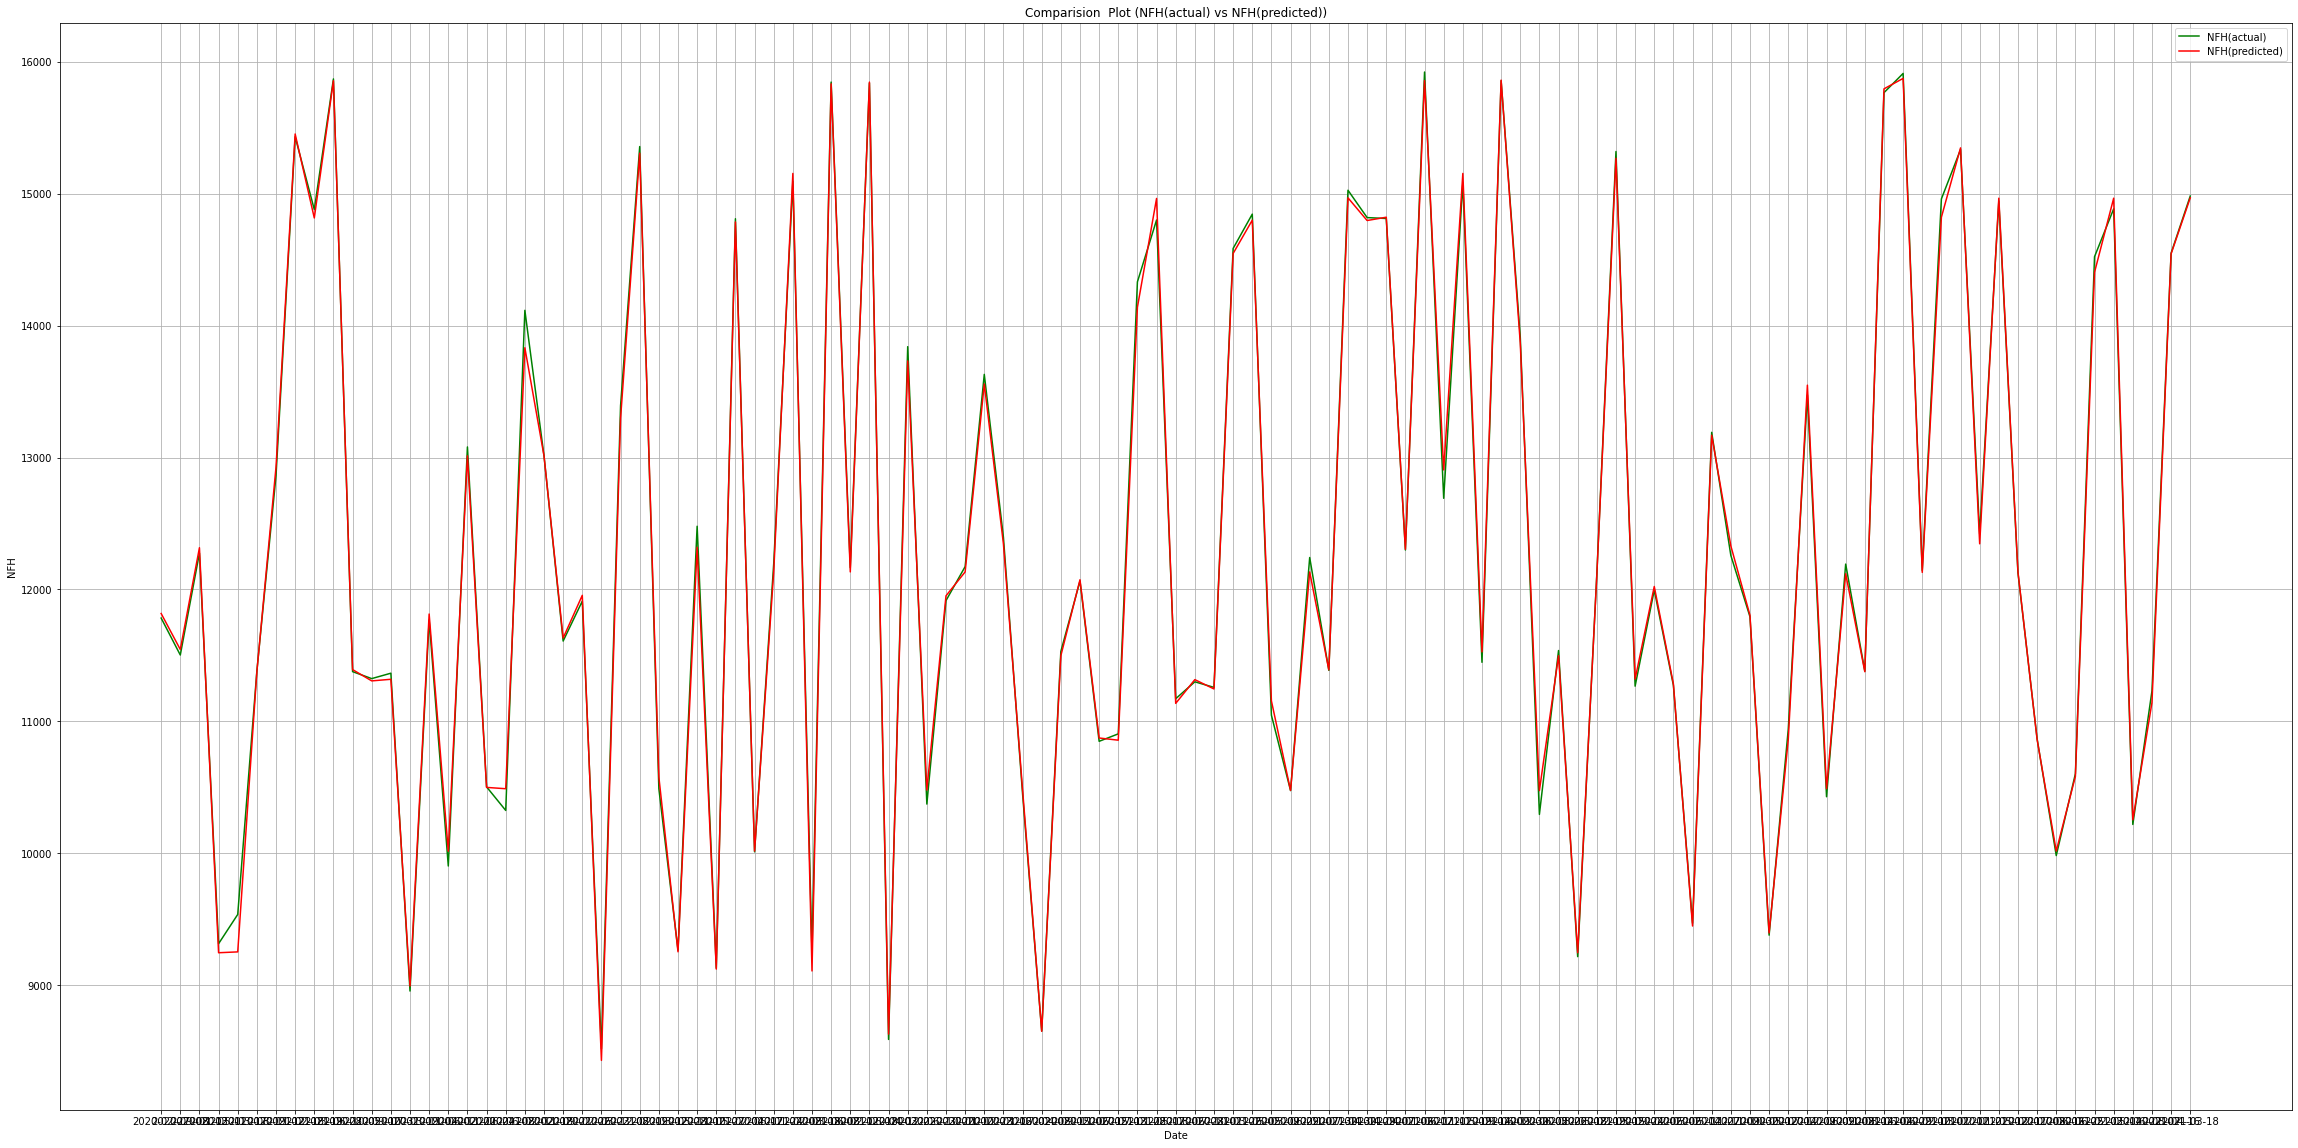

In [25]:
plt.figure(figsize=(40,20))
plt.plot(date,y_test,label='NFH(actual)',color='green')
plt.plot(date,y_pred,label='NFH(predicted)',color='red')
plt.grid(True)
plt.title('Comparision  Plot (NFH(actual) vs NFH(predicted))')
plt.legend()
plt.xlabel('Date')
plt.ylabel('NFH')
plt.style.use('fivethirtyeight')
plt.show()


### **NFL training/Prediction**

**Predicting NFL Using Train dataset which has actual samples of NFH and Test dataset which has predicted values of NFH  replacing the actual values so as to accomplish the goal of preditcing both the target columns one after the other ,i would replace the actual values of NFH with the predicted values (y_pred) so as to make predictions for NFL based on the predicted values of NFH and hence i term this mode as pipeline model**

### **Splitting the dataset into the Training set and Test dataframes (70% :train and 30%: test)**

**Note: Shuffling of data is active sir when train/test split occurs ,so as a result every time we run the code different sets of values would be catgeorised as train and test set based on which training and prediction would occur sir**

In [26]:
df2=df.copy()
df2=df2.drop(columns=['nfh'])
X=df2.iloc[:,:-1].values
y=df2.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.3)

In [27]:
df2

,Date(IST),NFO,NFC,FIIB,FIIS,FIIN,DIIB,DIIS,DIIN,August,December,CAD,DAD,DOD,NDAD,Currey,Flow,Shine,Vega,nfl
1,2020-01-02,12115.673242,12216.272367,2670.78,1982.02,688.76,3490.16,3426.21,63.95,1356.0,482.0,-0.01,0.3970,-0.98,0.72,-0.0520,0.0399,-0.10,-1.309999,12151.571552
2,2020-01-03,12195.406448,12251.196928,4514.35,3251.30,1263.05,2750.87,3780.07,-1029.2,879.0,973.0,-0.23,-0.5100,-1.33,0.46,0.4430,0.5648,0.08,1.550000,12173.355954
3,2020-01-06,12272.929018,12228.903255,3732.00,3835.84,-103.84,3778.78,3802.48,-23.7,360.0,1502.0,-0.17,0.0150,-0.21,-0.07,0.0877,-0.0690,-0.18,-0.170000,12181.887534
4,2020-01-07,12237.309351,12051.960005,3911.17,4593.40,-682.23,4205.16,3893.97,311.19,1248.0,578.0,-0.21,-0.0500,-0.02,-1.79,-0.0437,-0.0208,0.08,-0.060000,12030.371144
5,2020-01-08,12149.137851,12017.343536,4109.04,4624.89,-515.85,5162.02,4413.62,748.4,725.0,1109.0,0.56,0.3050,0.54,-0.59,-0.2980,-0.6992,-0.65,-0.340000,11985.555622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2021-06-24,15832.780716,15711.203010,7094.36,9985.30,-2890.94,5377.76,4239.00,1138.76,783.0,1186.0,0.67,0.2234,-0.04,-0.16,0.0900,0.0880,0.01,-0.349999,15673.598435
353,2021-06-25,15781.799179,15763.679655,6766.31,7445.15,-678.84,6844.01,5011.25,1832.76,1070.0,902.0,0.54,0.1000,0.18,0.27,-0.0515,0.1500,-0.08,-0.350000,15703.024907
354,2021-06-28,15829.576703,15838.276361,4275.71,5934.43,-1658.72,5634.19,4357.11,1277.08,1069.0,940.0,-0.90,-0.1242,-0.39,-0.96,0.1515,-0.3200,-0.19,0.140000,15764.937429
355,2021-06-29,15904.676773,15837.898386,10932.02,10815.39,116.63,8687.31,6877.26,1810.05,903.0,1084.0,-0.52,-0.3158,0.08,-0.26,0.0040,0.2000,-0.17,0.260000,15804.933350


In [28]:
X_train=X_train[:,1:]
X_train

array([[7471.89170849766, 7868.0367956646105, 9423.25, ...,
        -0.180300000000001, 0.469999999999999, -2.95000076293945],
       [15640.015613991001, 15606.5323612481, 11510.79, ...,
        0.190000000000001, -0.0899999999999999, -0.420000076293945],
       [9151.830602738, 8890.29435624395, 13613.73, ...,
        -0.0899999999999999, 0.900000000000002, 1.2300014495849598],
       ...,
       [11937.5904270483, 11994.905605413402, 6100.23, ..., -0.2651,
        -0.0100000000000016, 0.0699996948242188],
       [12038.784177489499, 11899.3630517823, 5356.93, ...,
        -0.501099999999999, -0.780000000000001, 2.81999969482422],
       [10750.9889562451, 10855.0879059817, 4960.3, ...,
        0.0068999999999999105, 0.780000000000001, -1.2200012207031299]],
      dtype=object)

In [29]:
date=X_test[:,:1]
X_test=X_test[:,1:]
X_test

array([[11756.458153451202, 11667.598379155701, 5548.34, ..., -0.5403,
        -1.31, 11.6000003814697],
       [11422.8636067176, 11403.559934808998, 3659.41, ...,
        -0.780000000000001, 0.149999999999999, 0.709999084472656],
       [12220.9665518771, 12211.087501453201, 4883.87, ...,
        -0.289899999999999, -0.400000000000002, -0.240000724792479],
       ...,
       [11150.439633709198, 11160.4636983646, 6034.73, ..., -0.2498,
        -0.629999999999999, -0.44000053405762096],
       [14458.2028002881, 14503.608249356399, 7512.32, ...,
        -0.0600000000000023, 0.25, -0.319999694824219],
       [14978.1818400173, 14764.0792571659, 7994.23, ..., -1.3, -0.27,
        2.3500003814697203]], dtype=object)

In [30]:
date=date.reshape(len(date),1)
date=date.flatten()

In [31]:
date

array(['2020-02-27', '2020-09-08', '2020-01-13', '2020-05-11',
       '2020-03-17', '2020-08-19', '2020-11-12', '2021-02-18',
       '2021-03-19', '2021-06-28', '2020-10-05', '2020-09-10',
       '2020-07-31', '2020-03-19', '2020-11-04', '2020-06-02',
       '2020-11-20', '2020-06-24', '2020-06-08', '2021-02-02',
       '2020-11-18', '2020-09-21', '2020-02-26', '2020-03-23',
       '2020-12-08', '2021-02-19', '2020-03-12', '2020-05-28',
       '2020-11-10', '2020-05-27', '2021-02-04', '2020-06-17',
       '2020-01-24', '2021-02-08', '2020-03-18', '2021-06-08',
       '2020-02-12', '2021-06-18', '2020-04-03', '2020-12-22',
       '2020-06-23', '2020-10-20', '2020-01-10', '2020-12-23',
       '2020-01-16', '2020-07-02', '2020-04-08', '2020-09-15',
       '2020-11-06', '2020-07-15', '2020-07-13', '2021-01-28',
       '2021-05-17', '2020-08-06', '2020-07-28', '2020-10-01',
       '2021-03-26', '2021-05-05', '2020-03-09', '2020-06-29',
       '2020-01-07', '2020-07-30', '2021-04-30', '2021-

In [32]:
y_test=y_test.reshape(len(y_test),1)
y_train=y_train.reshape(len(y_train),1)

In [33]:
y_pred1=run1(X_train, X_test, y_train, y_test)

[17:53:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [34]:
y_test=y_test.flatten()
y_test

array([11641.47107998, 11369.2284112 , 12153.12931046,  9164.42848068,
        8711.87539742, 11225.78879311, 12679.24032036, 15289.25681257,
       14525.1060375 , 15764.93742943, 11301.81348464, 11196.55672335,
       11151.97509525,  8254.26137206, 11634.12966184,  9677.1749855 ,
       12890.99246328, 10352.27502738, 10189.02095384, 13520.63742742,
       12882.11744046, 11489.70528597, 11781.98011347,  7783.53794632,
       13277.2972862 , 15200.91610381, 10203.48364301,  8990.48709089,
       12371.27083449,  8971.97131666, 14465.33544415,  9688.70639486,
       12087.3907205 , 14935.589764  ,  8613.86194967, 15750.56324479,
       12090.74330446, 15694.68306934,  8271.38692893, 13349.9014107 ,
       10236.40992547, 11795.55336469, 12035.41437092, 13216.47914214,
       12324.14871826, 10327.02058915,  8279.56991849, 11375.99021576,
       11949.23951039, 10677.24418472, 10800.15507641, 14017.69640688,
       14650.13459793, 10994.85260455, 11165.77114057, 11150.65054883,
      

In [35]:
y_pred1=y_pred1.reshape(len(y_pred1),1)
y_pred1=y_pred1.flatten()
y_pred1

array([11557.426 , 11342.545 , 12159.69  ,  9152.693 ,  9143.587 ,
       11270.453 , 12811.253 , 15307.429 , 14572.288 , 15688.205 ,
       11270.453 , 11140.405 , 11140.405 ,  8326.427 , 11650.596 ,
        9594.884 , 12811.253 , 10311.333 , 10111.033 , 13730.53  ,
       12811.253 , 11493.968 , 11747.764 ,  7883.7197, 13321.34  ,
       15206.687 , 10083.874 ,  8998.54  , 12249.819 ,  8998.54  ,
       14570.041 ,  9839.947 , 12032.4795, 14927.736 ,  8792.391 ,
       15741.86  , 12032.4795, 15541.463 ,  8328.835 , 13544.554 ,
       10091.096 , 11789.115 , 12019.943 , 13318.339 , 12241.366 ,
       10335.252 ,  8326.427 , 11423.917 , 12022.666 , 10644.546 ,
       10793.345 , 14029.911 , 14570.7705, 10920.845 , 11143.735 ,
       11127.829 , 14309.5205, 14565.729 , 10781.111 , 10431.553 ,
       12032.4795, 11187.347 , 14819.857 , 14563.3125, 14655.736 ,
       12230.541 , 15698.887 , 12817.55  , 14914.345 , 11353.353 ,
       15681.773 , 13709.934 , 10107.793 , 11410.648 ,  9081.6

In [36]:
def disp1(y_test,y_pred):
  for i in range(len(y_test)):
    for j in range(len(y_test)):
      if i==j:
        print("The actual value of NFL is {0}, the predicted value of NFL for the same is {1}".format(y_test[i],y_pred[j]))
      else:
        continue

In [37]:
disp1(y_test,y_pred1)

The actual value of NFL is 11641.471079981298, the predicted value of NFL for the same is 11557.42578125
The actual value of NFL is 11369.2284111983, the predicted value of NFL for the same is 11342.544921875
The actual value of NFL is 12153.1293104622, the predicted value of NFL for the same is 12159.6904296875
The actual value of NFL is 9164.42848067511, the predicted value of NFL for the same is 9152.693359375
The actual value of NFL is 8711.87539742362, the predicted value of NFL for the same is 9143.5869140625
The actual value of NFL is 11225.788793112, the predicted value of NFL for the same is 11270.453125
The actual value of NFL is 12679.240320356299, the predicted value of NFL for the same is 12811.2529296875
The actual value of NFL is 15289.2568125749, the predicted value of NFL for the same is 15307.4287109375
The actual value of NFL is 14525.106037504, the predicted value of NFL for the same is 14572.2880859375
The actual value of NFL is 15764.937429426001, the predicted va

In [38]:
col1=['Date','NFL(actual)','NFL(predicted)']
fg2=pd.DataFrame(columns = col1)
fg2['Date']=date
fg2['NFL(actual)']=y_test
fg2['NFL(predicted)']=y_pred1
fg2

,Date,NFL(actual),NFL(predicted)
0,2020-02-27,11641.471080,11557.425781
1,2020-09-08,11369.228411,11342.544922
2,2020-01-13,12153.129310,12159.690430
3,2020-05-11,9164.428481,9152.693359
4,2020-03-17,8711.875397,9143.586914
...,...,...,...
102,2021-05-14,14746.534002,14776.309570
103,2020-06-22,10004.574643,10102.381836
104,2020-08-07,11087.078088,11065.157227
105,2021-04-16,14280.071672,14309.238281


In [39]:
fg2.to_csv('Independent model analysis: NFL')

[2021-08-22 17:53:31] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:31] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:31] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:32] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


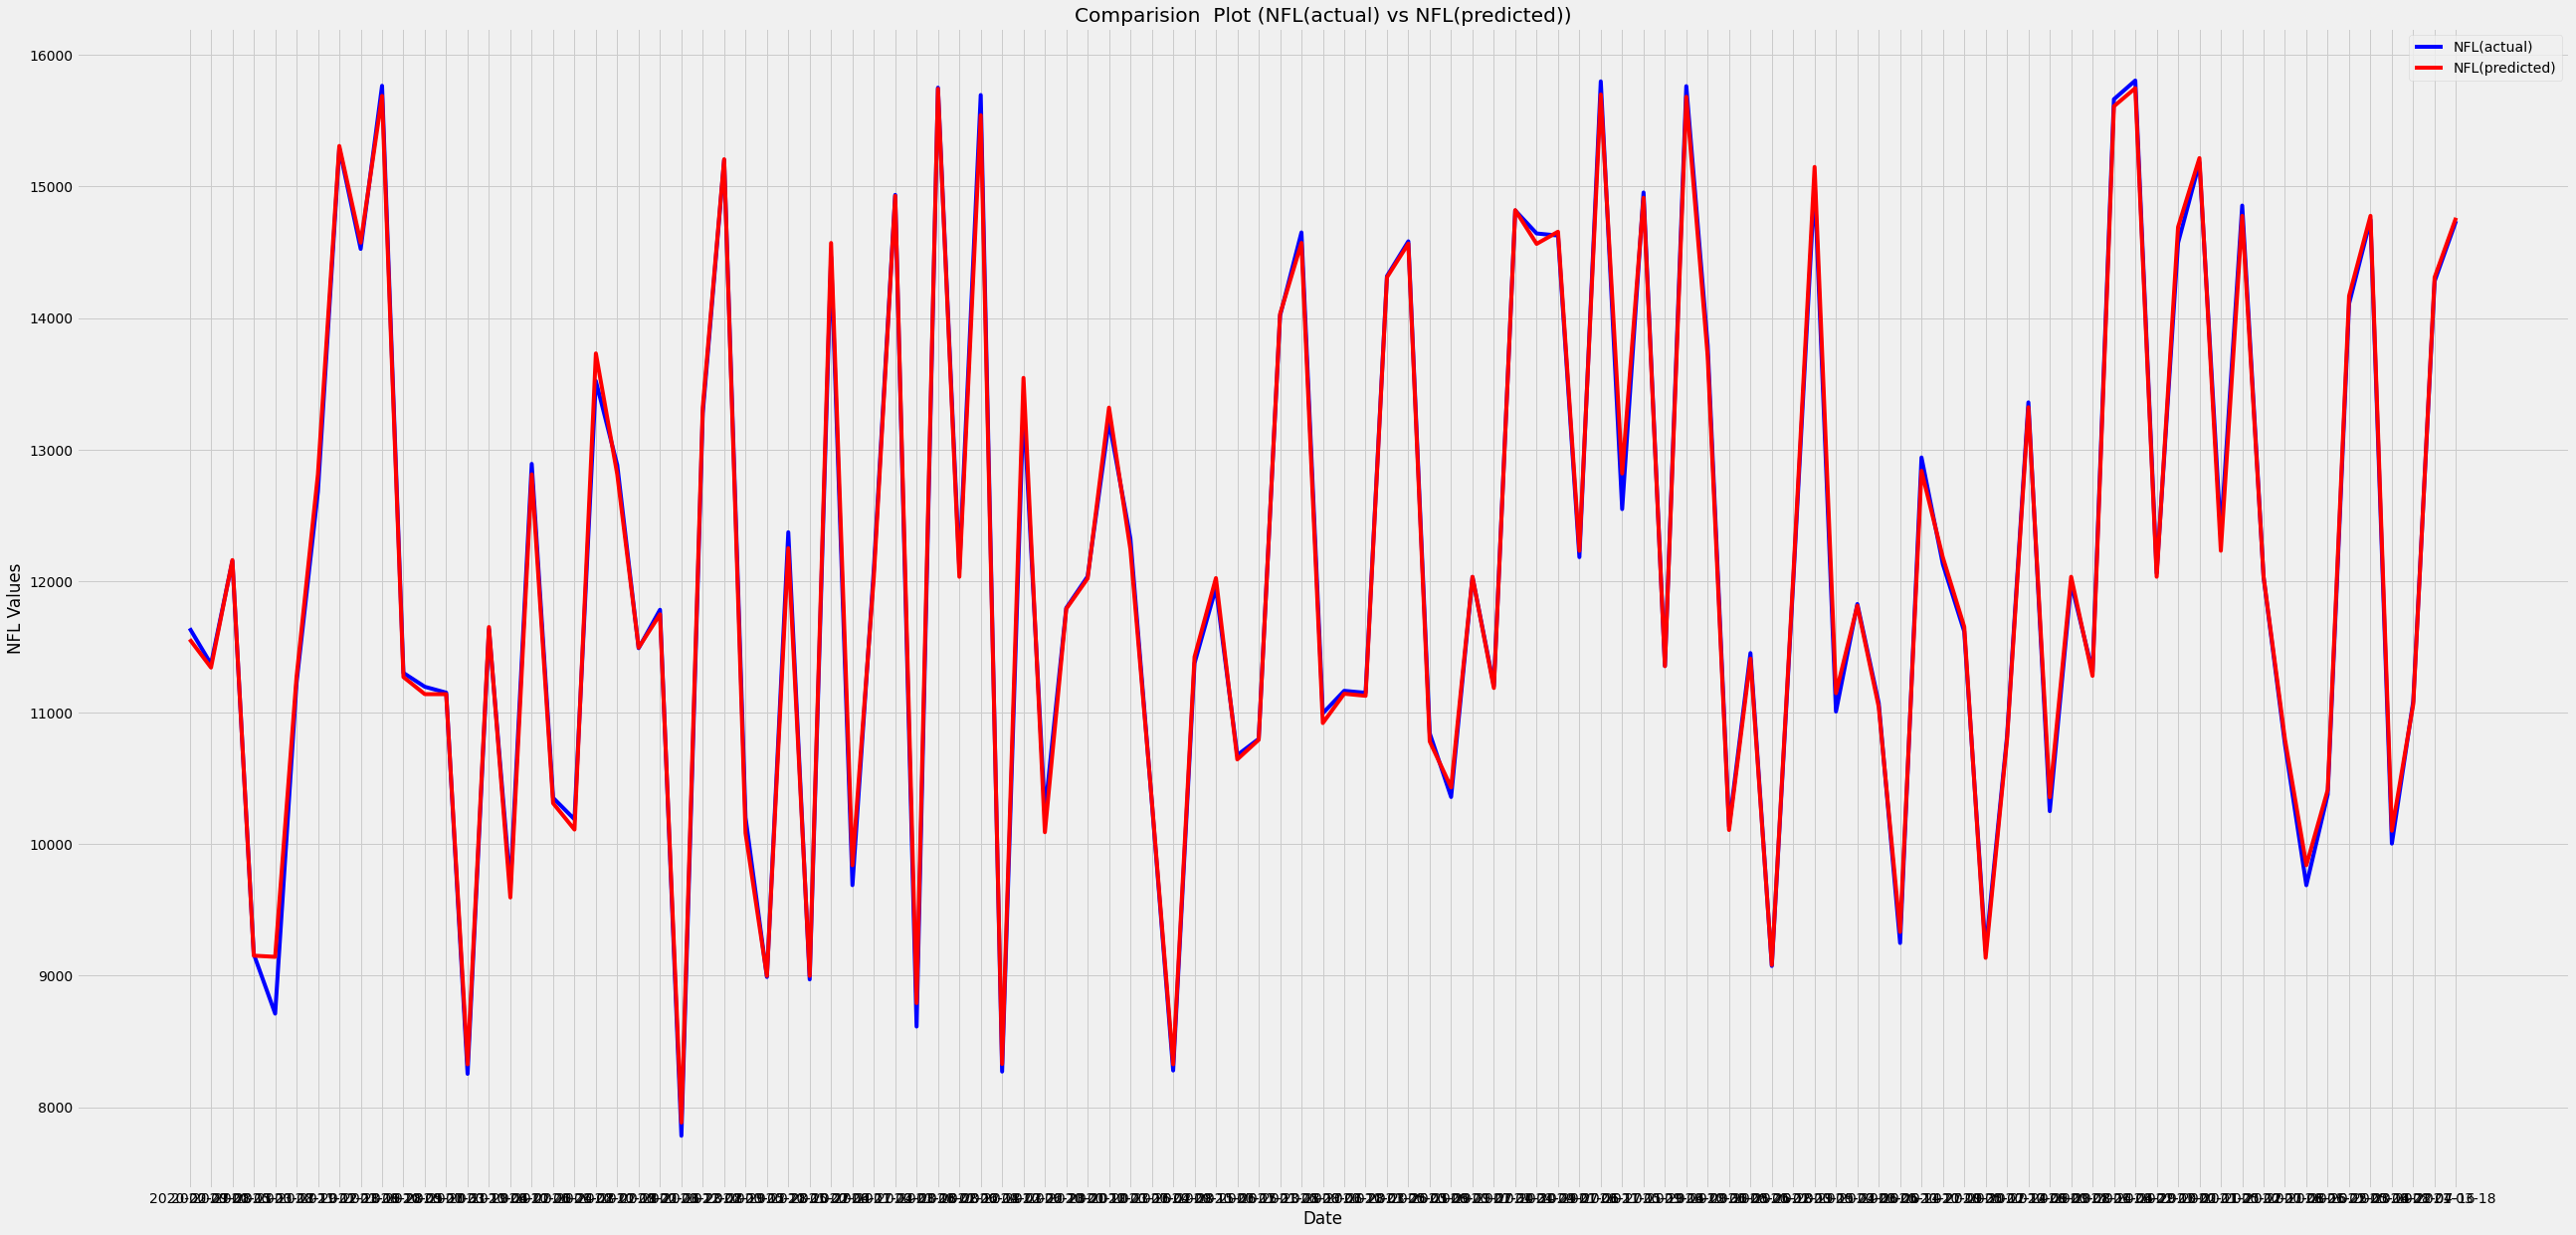

In [40]:
plt.figure(figsize=(40,20))
plt.plot(date,y_test,label='NFL(actual)',color='blue')
plt.plot(date,y_pred1,label='NFL(predicted)',color='red')
plt.grid(True)
plt.title('Comparision  Plot (NFL(actual) vs NFL(predicted))')
plt.legend()
plt.xlabel('Date')
plt.ylabel('NFL Values')
plt.style.use('fivethirtyeight')
plt.show()

In [41]:
col=['NFH(actual)','NFL(actual)','NFH(predicted)','NFL(predicted)']
fg=pd.DataFrame(columns = col)
fg.iloc[:,0]=fg1['NFH(actual)']
fg.iloc[:,1]=fg2['NFL(actual)']
fg.iloc[:,2]=y_pred
fg.iloc[:,3]=y_pred1
fg['Amount of Deviation:NFH (actual vs prediction)']=abs(fg['NFH(actual)']-fg['NFH(predicted)']).astype(float)
fg['Amount of Deviation:NFL (actual vs prediction)']=abs(fg['NFL(actual)']-fg['NFL(predicted)']).astype(float)
display(fg)
fg.to_csv('Independent model Analysis.csv')

,NFH(actual),NFL(actual),NFH(predicted),NFL(predicted),Amount of Deviation:NFH (actual vs prediction),Amount of Deviation:NFL (actual vs prediction)
0,11783.397529,11641.471080,11818.008789,11557.425781,34.611260,84.045299
1,11503.356931,11369.228411,11545.252930,11342.544922,41.895999,26.683489
2,12275.456494,12153.129310,12316.610352,12159.690430,41.153858,6.561119
3,9315.445273,9164.428481,9247.015625,9152.693359,68.429648,11.735121
4,9537.163894,8711.875397,9253.466797,9143.586914,283.697097,431.711517
...,...,...,...,...,...,...
102,14884.762852,14746.534002,14965.529297,14776.309570,80.766445,29.775568
103,10219.235630,10004.574643,10254.194336,10102.381836,34.958706,97.807193
104,11231.430572,11087.078088,11142.726562,11065.157227,88.704009,21.920861
105,14549.428616,14280.071672,14543.811523,14309.238281,5.617093,29.166609


## **Dependent model construction/implementation**

**For NFH model fitting/prediction we shall remove actual NFL values as depcited in the order of the columns in the actual dataset**

###**NFH training/prediction**

### **Splitting the dataset into the Training set and Test dataframes (70% :train and 30%: test)**

**Note: Shuffling of data is active sir when train/test split occurs ,so as a result every time we run the code different sets of values would be catgeorised as train and test set based on which training and prediction would occur sir**

In [42]:
df1=df.copy()
df1=df1.drop(columns=['nfl'])
X=df1.iloc[:,:-1].values
y=df1.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.3)

In [43]:
df1

,Date(IST),NFO,NFC,FIIB,FIIS,FIIN,DIIB,DIIS,DIIN,August,December,CAD,DAD,DOD,NDAD,Currey,Flow,Shine,Vega,nfh
1,2020-01-02,12115.673242,12216.272367,2670.78,1982.02,688.76,3490.16,3426.21,63.95,1356.0,482.0,-0.01,0.3970,-0.98,0.72,-0.0520,0.0399,-0.10,-1.309999,12177.119957
2,2020-01-03,12195.406448,12251.196928,4514.35,3251.30,1263.05,2750.87,3780.07,-1029.2,879.0,973.0,-0.23,-0.5100,-1.33,0.46,0.4430,0.5648,0.08,1.550000,12275.487382
3,2020-01-06,12272.929018,12228.903255,3732.00,3835.84,-103.84,3778.78,3802.48,-23.7,360.0,1502.0,-0.17,0.0150,-0.21,-0.07,0.0877,-0.0690,-0.18,-0.170000,12299.127043
4,2020-01-07,12237.309351,12051.960005,3911.17,4593.40,-682.23,4205.16,3893.97,311.19,1248.0,578.0,-0.21,-0.0500,-0.02,-1.79,-0.0437,-0.0208,0.08,-0.060000,12242.227141
5,2020-01-08,12149.137851,12017.343536,4109.04,4624.89,-515.85,5162.02,4413.62,748.4,725.0,1109.0,0.56,0.3050,0.54,-0.59,-0.2980,-0.6992,-0.65,-0.340000,12192.474725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2021-06-24,15832.780716,15711.203010,7094.36,9985.30,-2890.94,5377.76,4239.00,1138.76,783.0,1186.0,0.67,0.2234,-0.04,-0.16,0.0900,0.0880,0.01,-0.349999,15871.734957
353,2021-06-25,15781.799179,15763.679655,6766.31,7445.15,-678.84,6844.01,5011.25,1832.76,1070.0,902.0,0.54,0.1000,0.18,0.27,-0.0515,0.1500,-0.08,-0.350000,15846.875708
354,2021-06-28,15829.576703,15838.276361,4275.71,5934.43,-1658.72,5634.19,4357.11,1277.08,1069.0,940.0,-0.90,-0.1242,-0.39,-0.96,0.1515,-0.3200,-0.19,0.140000,15869.452759
355,2021-06-29,15904.676773,15837.898386,10932.02,10815.39,116.63,8687.31,6877.26,1810.05,903.0,1084.0,-0.52,-0.3158,0.08,-0.26,0.0040,0.2000,-0.17,0.260000,15910.968841


In [44]:
X_train=X_train[:,1:]
X_train

array([[7471.89170849766, 7868.0367956646105, 9423.25, ...,
        -0.180300000000001, 0.469999999999999, -2.95000076293945],
       [15640.015613991001, 15606.5323612481, 11510.79, ...,
        0.190000000000001, -0.0899999999999999, -0.420000076293945],
       [9151.830602738, 8890.29435624395, 13613.73, ...,
        -0.0899999999999999, 0.900000000000002, 1.2300014495849598],
       ...,
       [11937.5904270483, 11994.905605413402, 6100.23, ..., -0.2651,
        -0.0100000000000016, 0.0699996948242188],
       [12038.784177489499, 11899.3630517823, 5356.93, ...,
        -0.501099999999999, -0.780000000000001, 2.81999969482422],
       [10750.9889562451, 10855.0879059817, 4960.3, ...,
        0.0068999999999999105, 0.780000000000001, -1.2200012207031299]],
      dtype=object)

In [45]:
X_test

array([['2020-02-27', 11756.458153451202, 11667.598379155701, ...,
        -0.5403, -1.31, 11.6000003814697],
       ['2020-09-08', 11422.8636067176, 11403.559934808998, ...,
        -0.780000000000001, 0.149999999999999, 0.709999084472656],
       ['2020-01-13', 12220.9665518771, 12211.087501453201, ...,
        -0.289899999999999, -0.400000000000002, -0.240000724792479],
       ...,
       ['2020-08-07', 11150.439633709198, 11160.4636983646, ..., -0.2498,
        -0.629999999999999, -0.44000053405762096],
       ['2021-04-16', 14458.2028002881, 14503.608249356399, ...,
        -0.0600000000000023, 0.25, -0.319999694824219],
       ['2021-03-18', 14978.1818400173, 14764.0792571659, ..., -1.3,
        -0.27, 2.3500003814697203]], dtype=object)

In [46]:
date=X_test[:,:1]
X_test=X_test[:,1:]
X_test

array([[11756.458153451202, 11667.598379155701, 5548.34, ..., -0.5403,
        -1.31, 11.6000003814697],
       [11422.8636067176, 11403.559934808998, 3659.41, ...,
        -0.780000000000001, 0.149999999999999, 0.709999084472656],
       [12220.9665518771, 12211.087501453201, 4883.87, ...,
        -0.289899999999999, -0.400000000000002, -0.240000724792479],
       ...,
       [11150.439633709198, 11160.4636983646, 6034.73, ..., -0.2498,
        -0.629999999999999, -0.44000053405762096],
       [14458.2028002881, 14503.608249356399, 7512.32, ...,
        -0.0600000000000023, 0.25, -0.319999694824219],
       [14978.1818400173, 14764.0792571659, 7994.23, ..., -1.3, -0.27,
        2.3500003814697203]], dtype=object)

In [47]:
date=date.reshape(len(date),1)
date=date.flatten()

In [48]:
date

array(['2020-02-27', '2020-09-08', '2020-01-13', '2020-05-11',
       '2020-03-17', '2020-08-19', '2020-11-12', '2021-02-18',
       '2021-03-19', '2021-06-28', '2020-10-05', '2020-09-10',
       '2020-07-31', '2020-03-19', '2020-11-04', '2020-06-02',
       '2020-11-20', '2020-06-24', '2020-06-08', '2021-02-02',
       '2020-11-18', '2020-09-21', '2020-02-26', '2020-03-23',
       '2020-12-08', '2021-02-19', '2020-03-12', '2020-05-28',
       '2020-11-10', '2020-05-27', '2021-02-04', '2020-06-17',
       '2020-01-24', '2021-02-08', '2020-03-18', '2021-06-08',
       '2020-02-12', '2021-06-18', '2020-04-03', '2020-12-22',
       '2020-06-23', '2020-10-20', '2020-01-10', '2020-12-23',
       '2020-01-16', '2020-07-02', '2020-04-08', '2020-09-15',
       '2020-11-06', '2020-07-15', '2020-07-13', '2021-01-28',
       '2021-05-17', '2020-08-06', '2020-07-28', '2020-10-01',
       '2021-03-26', '2021-05-05', '2020-03-09', '2020-06-29',
       '2020-01-07', '2020-07-30', '2021-04-30', '2021-

In [49]:
y_test=y_test.reshape(len(y_test),1)
y_train=y_train.reshape(len(y_train),1)

In [50]:
y_pred1=run2(X_train, X_test, y_train, y_test)

[17:53:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [51]:
len(X_train)

248

In [52]:
len(y_train)

248

In [53]:
len(X_test)

107

In [54]:
len(y_test)

107

In [55]:
y_test=y_test.reshape(len(y_test),1)
y_test=y_test.flatten()
y_test

array([11783.39752922, 11503.35693102, 12275.4564939 ,  9315.44527291,
        9537.16389405, 11381.73883615, 12862.29640228, 15430.91737164,
       14879.51836625, 15869.45275948, 11377.45224585, 11324.600959  ,
       11365.54304724,  8956.75697577, 11768.28292342,  9904.39243504,
       13080.30794543, 10504.17512789, 10325.47024658, 14115.67135266,
       13013.44877167, 11609.16210746, 11911.6842784 ,  8518.21754164,
       13392.80324505, 15356.66772861, 10490.64954053,  9266.29369103,
       12479.26893845,  9130.20497268, 14809.76579376, 10011.68439898,
       12194.88582122, 15094.62171557,  9246.37090565, 15845.47894603,
       12165.47269289, 15838.12391153,  8589.96967022, 13840.28603955,
       10373.72130637, 11915.66449669, 12173.39419023, 13630.23672551,
       12396.63741747, 10451.36908744,  8653.77102273, 11530.57722802,
       12064.39216754, 10849.26832683, 10905.82566234, 14331.36912919,
       14800.15424795, 11172.04549535, 11300.26438429, 11258.13037807,
      

In [56]:
y_pred=y_pred.reshape(len(y_pred),1)
y_pred=y_pred.flatten()
y_pred

array([11818.009 , 11545.253 , 12316.61  ,  9247.016 ,  9253.467 ,
       11376.698 , 12927.519 , 15452.052 , 14815.562 , 15855.865 ,
       11393.008 , 11307.267 , 11319.447 ,  8994.574 , 11814.044 ,
       10016.3545, 13013.01  , 10500.07  , 10490.016 , 13832.068 ,
       13013.01  , 11632.167 , 11955.716 ,  8431.251 , 13297.253 ,
       15306.752 , 10579.054 ,  9254.115 , 12320.218 ,  9123.1455,
       14785.238 , 10017.549 , 12133.146 , 15153.097 ,  9108.992 ,
       15832.167 , 12133.146 , 15845.443 ,  8630.674 , 13732.21  ,
       10479.795 , 11951.868 , 12133.146 , 13557.653 , 12346.127 ,
       10484.155 ,  8651.701 , 11498.05  , 12073.837 , 10874.483 ,
       10857.901 , 14138.813 , 14963.589 , 11136.866 , 11316.757 ,
       11246.171 , 14546.352 , 14798.843 , 11155.727 , 10477.325 ,
       12133.146 , 11391.04  , 14968.074 , 14796.264 , 14821.275 ,
       12304.952 , 15856.851 , 12905.931 , 15153.097 , 11527.01  ,
       15860.233 , 13867.63  , 10475.762 , 11498.05  ,  9247.0

In [57]:
disp(y_test,y_pred)

The actual value of NFH is 11783.397529215601, the predicted value of NFH for the same is 11818.0087890625
The actual value of NFH is 11503.3569310154, the predicted value of NFH for the same is 11545.2529296875
The actual value of NFH is 12275.4564939041, the predicted value of NFH for the same is 12316.6103515625
The actual value of NFH is 9315.4452729088, the predicted value of NFH for the same is 9247.015625
The actual value of NFH is 9537.16389404992, the predicted value of NFH for the same is 9253.466796875
The actual value of NFH is 11381.738836153701, the predicted value of NFH for the same is 11376.6982421875
The actual value of NFH is 12862.296402277, the predicted value of NFH for the same is 12927.5185546875
The actual value of NFH is 15430.917371641899, the predicted value of NFH for the same is 15452.0517578125
The actual value of NFH is 14879.518366246799, the predicted value of NFH for the same is 14815.5615234375
The actual value of NFH is 15869.452759483502, the predi

In [58]:
col=['Date','NFH(actual)','NFH(predicted)']
fg3=pd.DataFrame(columns = col)
fg3['Date']=date
fg3['NFH(actual)']=y_test
fg3['NFH(predicted)']=y_pred
fg3

,Date,NFH(actual),NFH(predicted)
0,2020-02-27,11783.397529,11818.008789
1,2020-09-08,11503.356931,11545.252930
2,2020-01-13,12275.456494,12316.610352
3,2020-05-11,9315.445273,9247.015625
4,2020-03-17,9537.163894,9253.466797
...,...,...,...
102,2021-05-14,14884.762852,14965.529297
103,2020-06-22,10219.235630,10254.194336
104,2020-08-07,11231.430572,11142.726562
105,2021-04-16,14549.428616,14543.811523


In [59]:
fg3.to_csv('Dependent model analysis: NFH')

[2021-08-22 17:53:41] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:41] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:41] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:41] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


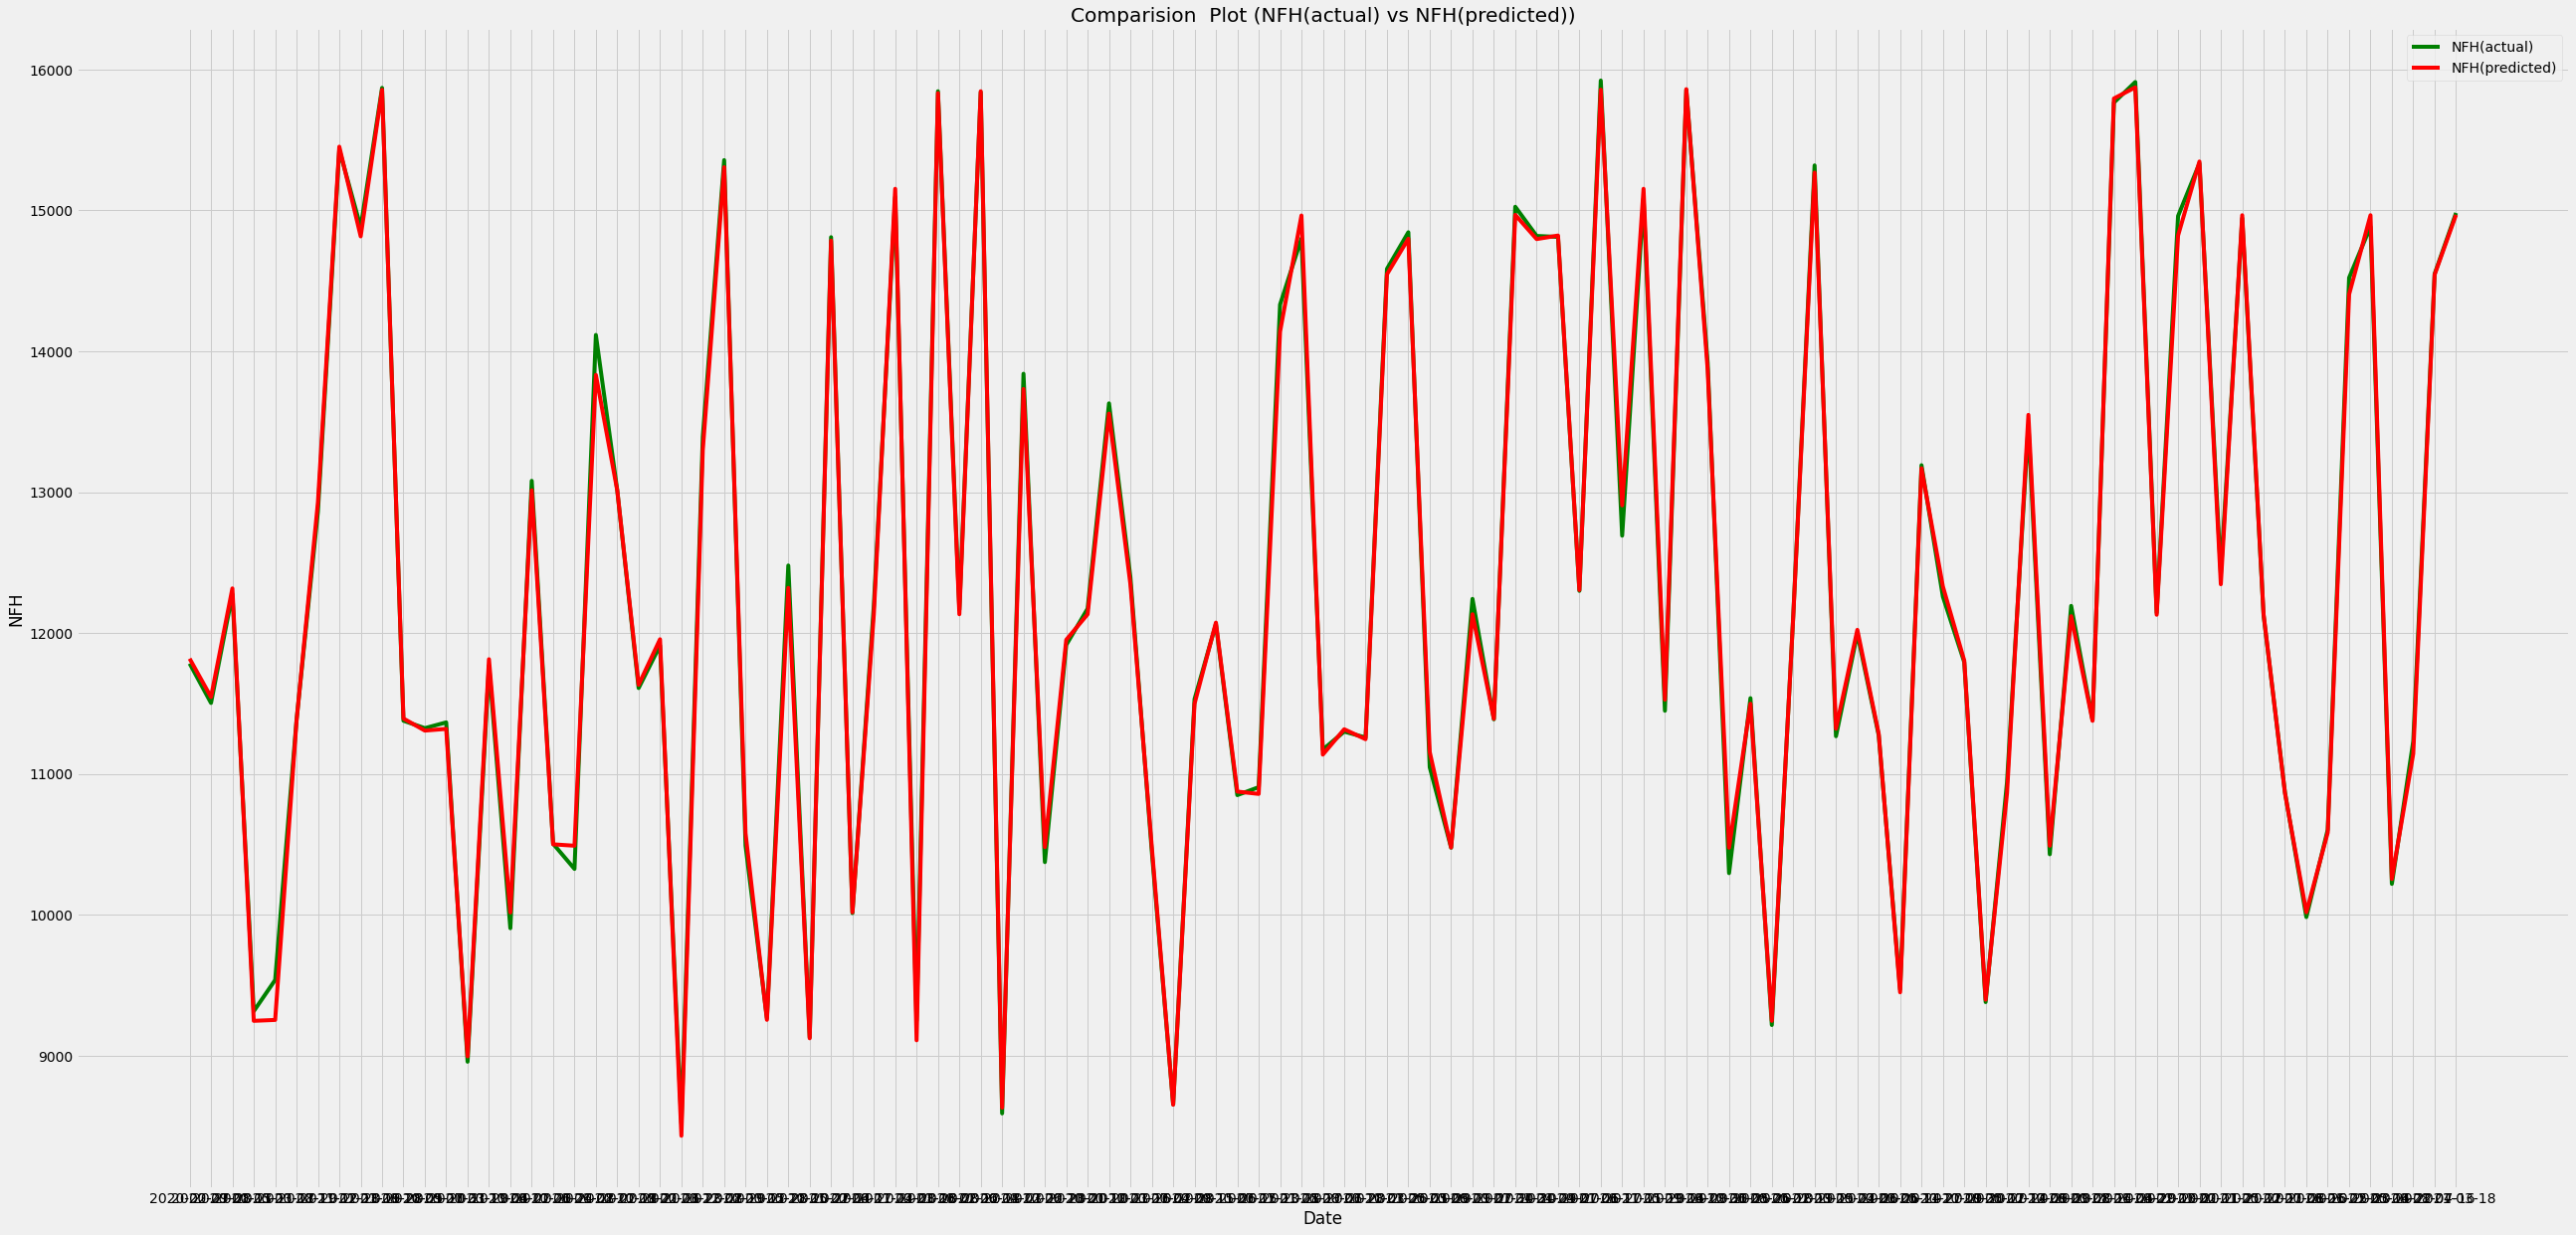

In [60]:
plt.figure(figsize=(40,20))
plt.plot(date,y_test,label='NFH(actual)',color='green')
plt.plot(date,y_pred,label='NFH(predicted)',color='red')
plt.grid(True)
plt.title('Comparision  Plot (NFH(actual) vs NFH(predicted))')
plt.legend()
plt.xlabel('Date')
plt.ylabel('NFH')
plt.style.use('fivethirtyeight')
plt.show()


### **NFL training/prediction**

### **Splitting the dataset into the Training set and Test dataframes (70% :train and 30%: test)**

**Note: Shuffling of data is active sir when train/test split occurs ,so as a result every time we run the code different sets of values would be catgeorised as train and test set based on which training and prediction would occur sir**

In [61]:
df2=df.copy()
X=df2.iloc[:,:-1].values
y=df2.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.3)

In [62]:
df2

,Date(IST),NFO,NFC,FIIB,FIIS,FIIN,DIIB,DIIS,DIIN,August,December,CAD,DAD,DOD,NDAD,Currey,Flow,Shine,Vega,nfh,nfl
1,2020-01-02,12115.673242,12216.272367,2670.78,1982.02,688.76,3490.16,3426.21,63.95,1356.0,482.0,-0.01,0.3970,-0.98,0.72,-0.0520,0.0399,-0.10,-1.309999,12177.119957,12151.571552
2,2020-01-03,12195.406448,12251.196928,4514.35,3251.30,1263.05,2750.87,3780.07,-1029.2,879.0,973.0,-0.23,-0.5100,-1.33,0.46,0.4430,0.5648,0.08,1.550000,12275.487382,12173.355954
3,2020-01-06,12272.929018,12228.903255,3732.00,3835.84,-103.84,3778.78,3802.48,-23.7,360.0,1502.0,-0.17,0.0150,-0.21,-0.07,0.0877,-0.0690,-0.18,-0.170000,12299.127043,12181.887534
4,2020-01-07,12237.309351,12051.960005,3911.17,4593.40,-682.23,4205.16,3893.97,311.19,1248.0,578.0,-0.21,-0.0500,-0.02,-1.79,-0.0437,-0.0208,0.08,-0.060000,12242.227141,12030.371144
5,2020-01-08,12149.137851,12017.343536,4109.04,4624.89,-515.85,5162.02,4413.62,748.4,725.0,1109.0,0.56,0.3050,0.54,-0.59,-0.2980,-0.6992,-0.65,-0.340000,12192.474725,11985.555622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2021-06-24,15832.780716,15711.203010,7094.36,9985.30,-2890.94,5377.76,4239.00,1138.76,783.0,1186.0,0.67,0.2234,-0.04,-0.16,0.0900,0.0880,0.01,-0.349999,15871.734957,15673.598435
353,2021-06-25,15781.799179,15763.679655,6766.31,7445.15,-678.84,6844.01,5011.25,1832.76,1070.0,902.0,0.54,0.1000,0.18,0.27,-0.0515,0.1500,-0.08,-0.350000,15846.875708,15703.024907
354,2021-06-28,15829.576703,15838.276361,4275.71,5934.43,-1658.72,5634.19,4357.11,1277.08,1069.0,940.0,-0.90,-0.1242,-0.39,-0.96,0.1515,-0.3200,-0.19,0.140000,15869.452759,15764.937429
355,2021-06-29,15904.676773,15837.898386,10932.02,10815.39,116.63,8687.31,6877.26,1810.05,903.0,1084.0,-0.52,-0.3158,0.08,-0.26,0.0040,0.2000,-0.17,0.260000,15910.968841,15804.933350


In [63]:
X_train=X_train[:,1:]
X_train

array([[7471.89170849766, 7868.0367956646105, 9423.25, ...,
        0.469999999999999, -2.95000076293945, 7988.390033328879],
       [15640.015613991001, 15606.5323612481, 11510.79, ...,
        -0.0899999999999999, -0.420000076293945, 15671.609780383602],
       [9151.830602738, 8890.29435624395, 13613.73, ...,
        0.900000000000002, 1.2300014495849598, 9144.8287428254],
       ...,
       [11937.5904270483, 11994.905605413402, 6100.23, ...,
        -0.0100000000000016, 0.0699996948242188, 12024.303397277801],
       [12038.784177489499, 11899.3630517823, 5356.93, ...,
        -0.780000000000001, 2.81999969482422, 12045.397915803402],
       [10750.9889562451, 10855.0879059817, 4960.3, ...,
        0.780000000000001, -1.2200012207031299, 10901.3909867828]],
      dtype=object)

In [64]:
date=X_test[:,:1]
X_test=X_test[:,1:]
X_test

array([[11756.458153451202, 11667.598379155701, 5548.34, ..., -1.31,
        11.6000003814697, 11783.397529215601],
       [11422.8636067176, 11403.559934808998, 3659.41, ...,
        0.149999999999999, 0.709999084472656, 11503.3569310154],
       [12220.9665518771, 12211.087501453201, 4883.87, ...,
        -0.400000000000002, -0.240000724792479, 12275.4564939041],
       ...,
       [11150.439633709198, 11160.4636983646, 6034.73, ...,
        -0.629999999999999, -0.44000053405762096, 11231.4305718498],
       [14458.2028002881, 14503.608249356399, 7512.32, ..., 0.25,
        -0.319999694824219, 14549.4286159399],
       [14978.1818400173, 14764.0792571659, 7994.23, ..., -0.27,
        2.3500003814697203, 14981.756971204399]], dtype=object)

In [65]:
date=date.reshape(len(date),1)
date=date.flatten()

In [66]:
date

array(['2020-02-27', '2020-09-08', '2020-01-13', '2020-05-11',
       '2020-03-17', '2020-08-19', '2020-11-12', '2021-02-18',
       '2021-03-19', '2021-06-28', '2020-10-05', '2020-09-10',
       '2020-07-31', '2020-03-19', '2020-11-04', '2020-06-02',
       '2020-11-20', '2020-06-24', '2020-06-08', '2021-02-02',
       '2020-11-18', '2020-09-21', '2020-02-26', '2020-03-23',
       '2020-12-08', '2021-02-19', '2020-03-12', '2020-05-28',
       '2020-11-10', '2020-05-27', '2021-02-04', '2020-06-17',
       '2020-01-24', '2021-02-08', '2020-03-18', '2021-06-08',
       '2020-02-12', '2021-06-18', '2020-04-03', '2020-12-22',
       '2020-06-23', '2020-10-20', '2020-01-10', '2020-12-23',
       '2020-01-16', '2020-07-02', '2020-04-08', '2020-09-15',
       '2020-11-06', '2020-07-15', '2020-07-13', '2021-01-28',
       '2021-05-17', '2020-08-06', '2020-07-28', '2020-10-01',
       '2021-03-26', '2021-05-05', '2020-03-09', '2020-06-29',
       '2020-01-07', '2020-07-30', '2021-04-30', '2021-

In [67]:
y_test=y_test.reshape(len(y_test),1)
y_train=y_train.reshape(len(y_train),1)

In [68]:
y_pred1=run3(X_train, X_test, y_train, y_test)

[17:53:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [69]:
y_test=y_test.flatten()
y_test

array([11641.47107998, 11369.2284112 , 12153.12931046,  9164.42848068,
        8711.87539742, 11225.78879311, 12679.24032036, 15289.25681257,
       14525.1060375 , 15764.93742943, 11301.81348464, 11196.55672335,
       11151.97509525,  8254.26137206, 11634.12966184,  9677.1749855 ,
       12890.99246328, 10352.27502738, 10189.02095384, 13520.63742742,
       12882.11744046, 11489.70528597, 11781.98011347,  7783.53794632,
       13277.2972862 , 15200.91610381, 10203.48364301,  8990.48709089,
       12371.27083449,  8971.97131666, 14465.33544415,  9688.70639486,
       12087.3907205 , 14935.589764  ,  8613.86194967, 15750.56324479,
       12090.74330446, 15694.68306934,  8271.38692893, 13349.9014107 ,
       10236.40992547, 11795.55336469, 12035.41437092, 13216.47914214,
       12324.14871826, 10327.02058915,  8279.56991849, 11375.99021576,
       11949.23951039, 10677.24418472, 10800.15507641, 14017.69640688,
       14650.13459793, 10994.85260455, 11165.77114057, 11150.65054883,
      

In [70]:
y_pred1=y_pred1.reshape(len(y_pred1),1)
y_pred1=y_pred1.flatten()
y_pred1

array([11570.664 , 11325.171 , 12154.339 ,  9204.413 ,  8909.334 ,
       11224.613 , 12786.686 , 15245.091 , 14511.894 , 15736.413 ,
       11310.617 , 11142.94  , 11136.216 ,  8468.503 , 11654.763 ,
        9639.952 , 12836.505 , 10329.14  , 10109.325 , 13540.944 ,
       12808.664 , 11501.268 , 11804.682 ,  7712.6963, 13333.452 ,
       15210.017 , 10094.377 ,  8918.761 , 12231.036 ,  8910.94  ,
       14492.408 ,  9854.231 , 12017.593 , 14946.882 ,  8805.013 ,
       15762.172 , 12026.943 , 15609.202 ,  8478.514 , 13498.041 ,
       10109.675 , 11817.372 , 12026.943 , 13325.1   , 12237.507 ,
       10337.1   ,  8351.029 , 11451.41  , 12022.267 , 10635.217 ,
       10789.014 , 14015.289 , 14689.727 , 10929.159 , 11191.85  ,
       11136.216 , 14319.66  , 14549.289 , 10791.064 , 10357.103 ,
       12047.964 , 11194.218 , 14834.214 , 14520.188 , 14689.727 ,
       12222.41  , 15693.823 , 12815.011 , 14948.788 , 11370.794 ,
       15759.185 , 13705.663 , 10109.64  , 11454.056 ,  9081.8

In [71]:
disp1(y_test,y_pred1)

The actual value of NFL is 11641.471079981298, the predicted value of NFL for the same is 11570.6640625
The actual value of NFL is 11369.2284111983, the predicted value of NFL for the same is 11325.1708984375
The actual value of NFL is 12153.1293104622, the predicted value of NFL for the same is 12154.3388671875
The actual value of NFL is 9164.42848067511, the predicted value of NFL for the same is 9204.4130859375
The actual value of NFL is 8711.87539742362, the predicted value of NFL for the same is 8909.333984375
The actual value of NFL is 11225.788793112, the predicted value of NFL for the same is 11224.61328125
The actual value of NFL is 12679.240320356299, the predicted value of NFL for the same is 12786.685546875
The actual value of NFL is 15289.2568125749, the predicted value of NFL for the same is 15245.0908203125
The actual value of NFL is 14525.106037504, the predicted value of NFL for the same is 14511.8935546875
The actual value of NFL is 15764.937429426001, the predicted v

In [72]:
col1=['Date','NFL(actual)','NFL(predicted)']
fg4=pd.DataFrame(columns = col1)
fg4['Date']=date
fg4['NFL(actual)']=y_test
fg4['NFL(predicted)']=y_pred1
fg4

,Date,NFL(actual),NFL(predicted)
0,2020-02-27,11641.471080,11570.664062
1,2020-09-08,11369.228411,11325.170898
2,2020-01-13,12153.129310,12154.338867
3,2020-05-11,9164.428481,9204.413086
4,2020-03-17,8711.875397,8909.333984
...,...,...,...
102,2021-05-14,14746.534002,14828.329102
103,2020-06-22,10004.574643,10093.594727
104,2020-08-07,11087.078088,11056.219727
105,2021-04-16,14280.071672,14387.779297


In [73]:
fg4.to_csv('Independent model analysis: NFL')

[2021-08-22 17:53:48] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:48] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:48] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:48] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


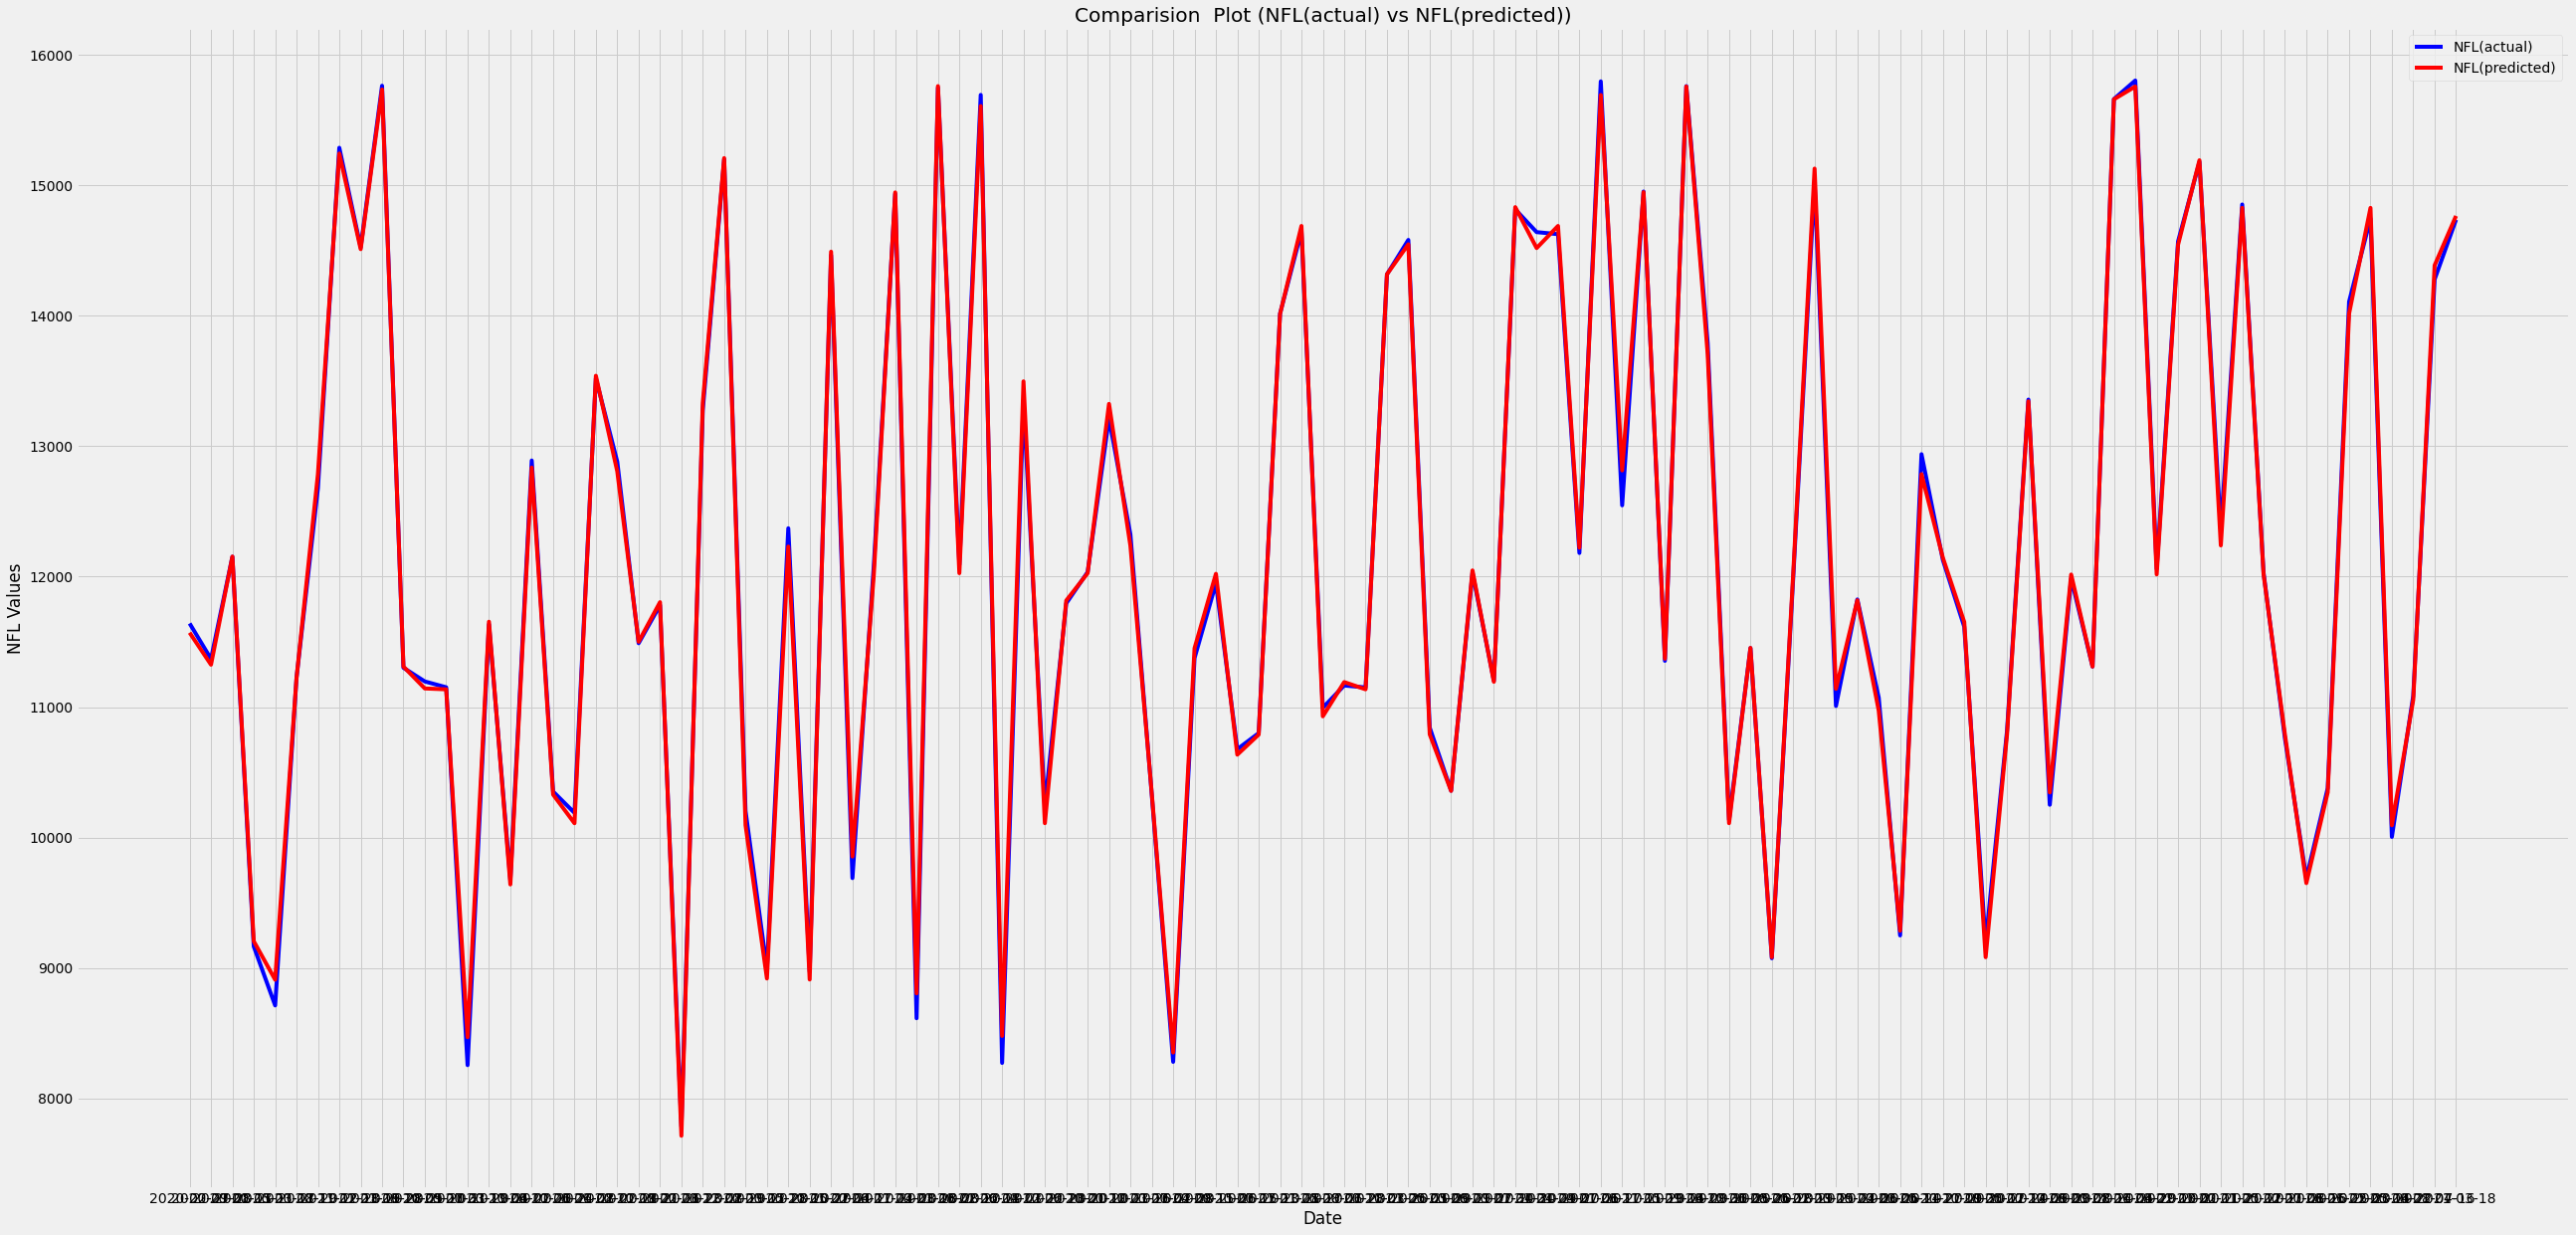

In [74]:
plt.figure(figsize=(40,20))
plt.plot(date,y_test,label='NFL(actual)',color='blue')
plt.plot(date,y_pred1,label='NFL(predicted)',color='red')
plt.grid(True)
plt.title('Comparision  Plot (NFL(actual) vs NFL(predicted))')
plt.legend()
plt.xlabel('Date')
plt.ylabel('NFL Values')
plt.style.use('fivethirtyeight')
plt.show()

In [75]:
col=['NFH(actual)','NFL(actual)','NFH(predicted)','NFL(predicted)']
fg1=pd.DataFrame(columns = col)
fg1.iloc[:,0]=fg3['NFH(actual)']
fg1.iloc[:,1]=fg4['NFL(actual)']
fg1.iloc[:,2]=y_pred
fg1.iloc[:,3]=y_pred1
fg1['Amount of Deviation:NFH (actual vs prediction)']=abs(fg1['NFH(actual)']-fg1['NFH(predicted)']).astype(float)
fg1['Amount of Deviation:NFL (actual vs prediction)']=abs(fg1['NFL(actual)']-fg1['NFL(predicted)']).astype(float)
fg1.to_csv('Dependent model Analysis.csv')
display(fg1)

,NFH(actual),NFL(actual),NFH(predicted),NFL(predicted),Amount of Deviation:NFH (actual vs prediction),Amount of Deviation:NFL (actual vs prediction)
0,11783.397529,11641.471080,11818.008789,11570.664062,34.611260,70.807017
1,11503.356931,11369.228411,11545.252930,11325.170898,41.895999,44.057513
2,12275.456494,12153.129310,12316.610352,12154.338867,41.153858,1.209557
3,9315.445273,9164.428481,9247.015625,9204.413086,68.429648,39.984605
4,9537.163894,8711.875397,9253.466797,8909.333984,283.697097,197.458587
...,...,...,...,...,...,...
102,14884.762852,14746.534002,14965.529297,14828.329102,80.766445,81.795099
103,10219.235630,10004.574643,10254.194336,10093.594727,34.958706,89.020084
104,11231.430572,11087.078088,11142.726562,11056.219727,88.704009,30.858361
105,14549.428616,14280.071672,14543.811523,14387.779297,5.617093,107.707625


### **Comparative Analysis between Dependent and Independent model algorithms**

In [76]:
d=pd.read_csv('Dependent model Analysis.csv')
id=pd.read_csv('Independent model Analysis.csv')

**Graphical Analysis of NFH values**

[2021-08-22 17:53:50] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:50] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:50] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:50] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


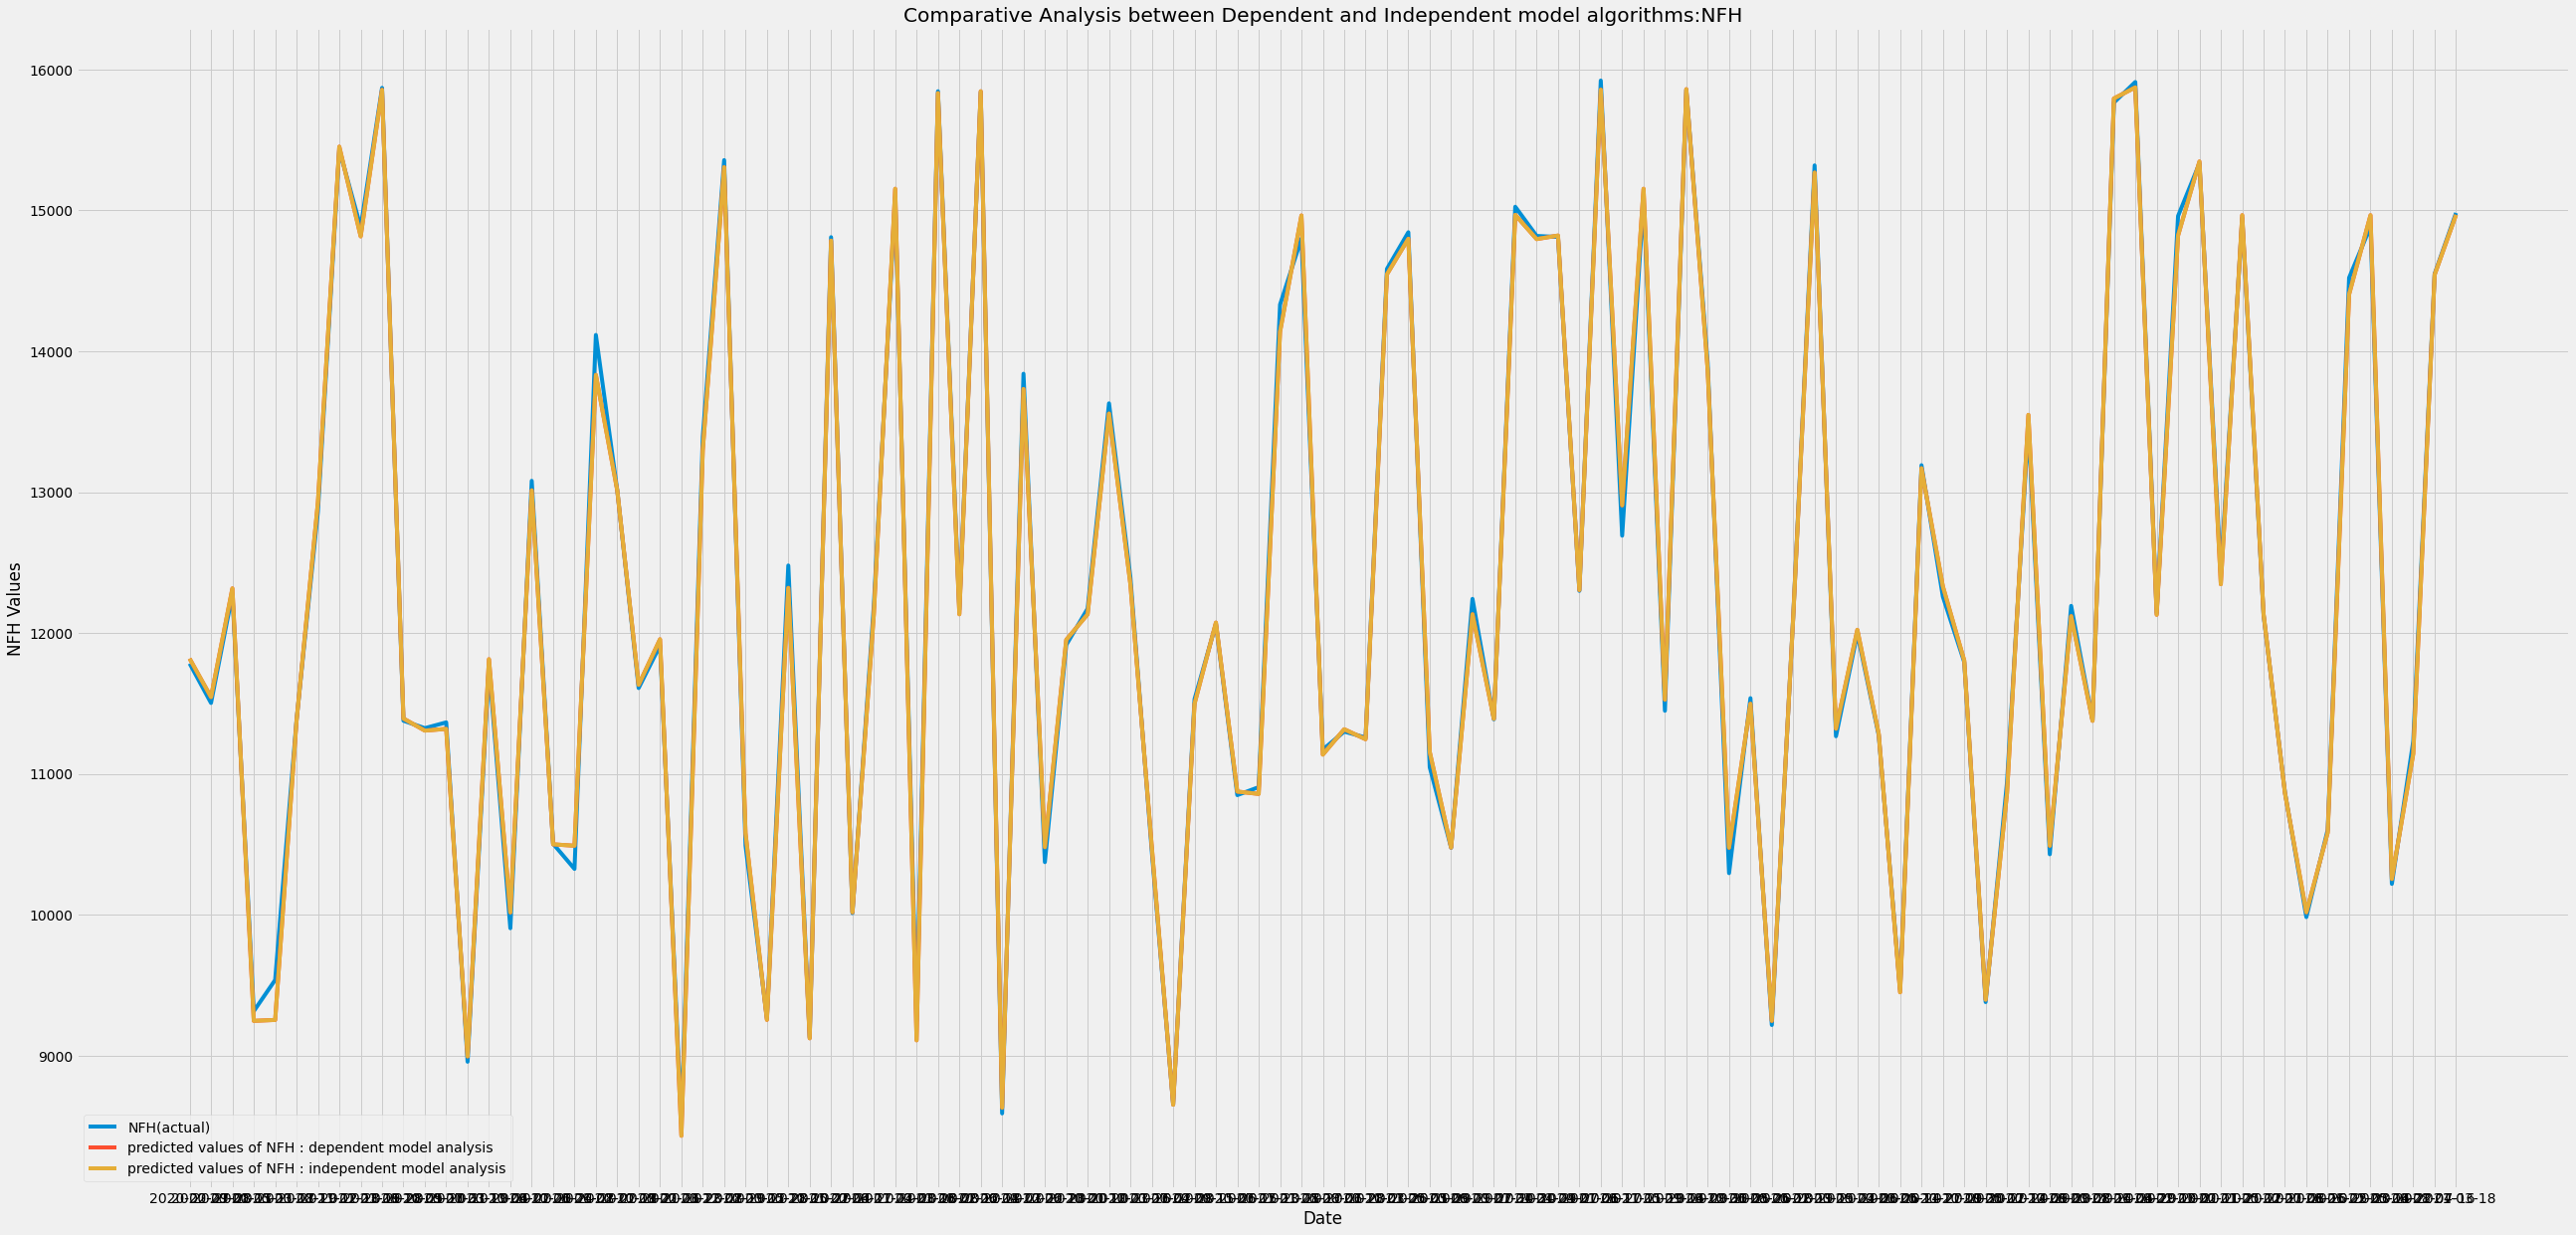

In [77]:
plt.figure(figsize=(40,20))
plt.plot(date,d['NFH(actual)'],label='NFH(actual)')
plt.plot(date,d['NFH(predicted)'],label='predicted values of NFH : dependent model analysis')
plt.plot(date,id['NFH(predicted)'],label='predicted values of NFH : independent model analysis')
plt.grid(True)
plt.title('Comparative Analysis between Dependent and Independent model algorithms:NFH')
plt.legend()
plt.xlabel('Date')
plt.ylabel('NFH Values')
plt.style.use('fivethirtyeight')
plt.show()

**Amount of Deviation between the actual values and the predicted values for both the models based on NFH**

[2021-08-22 17:53:51] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:51] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:51] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:51] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


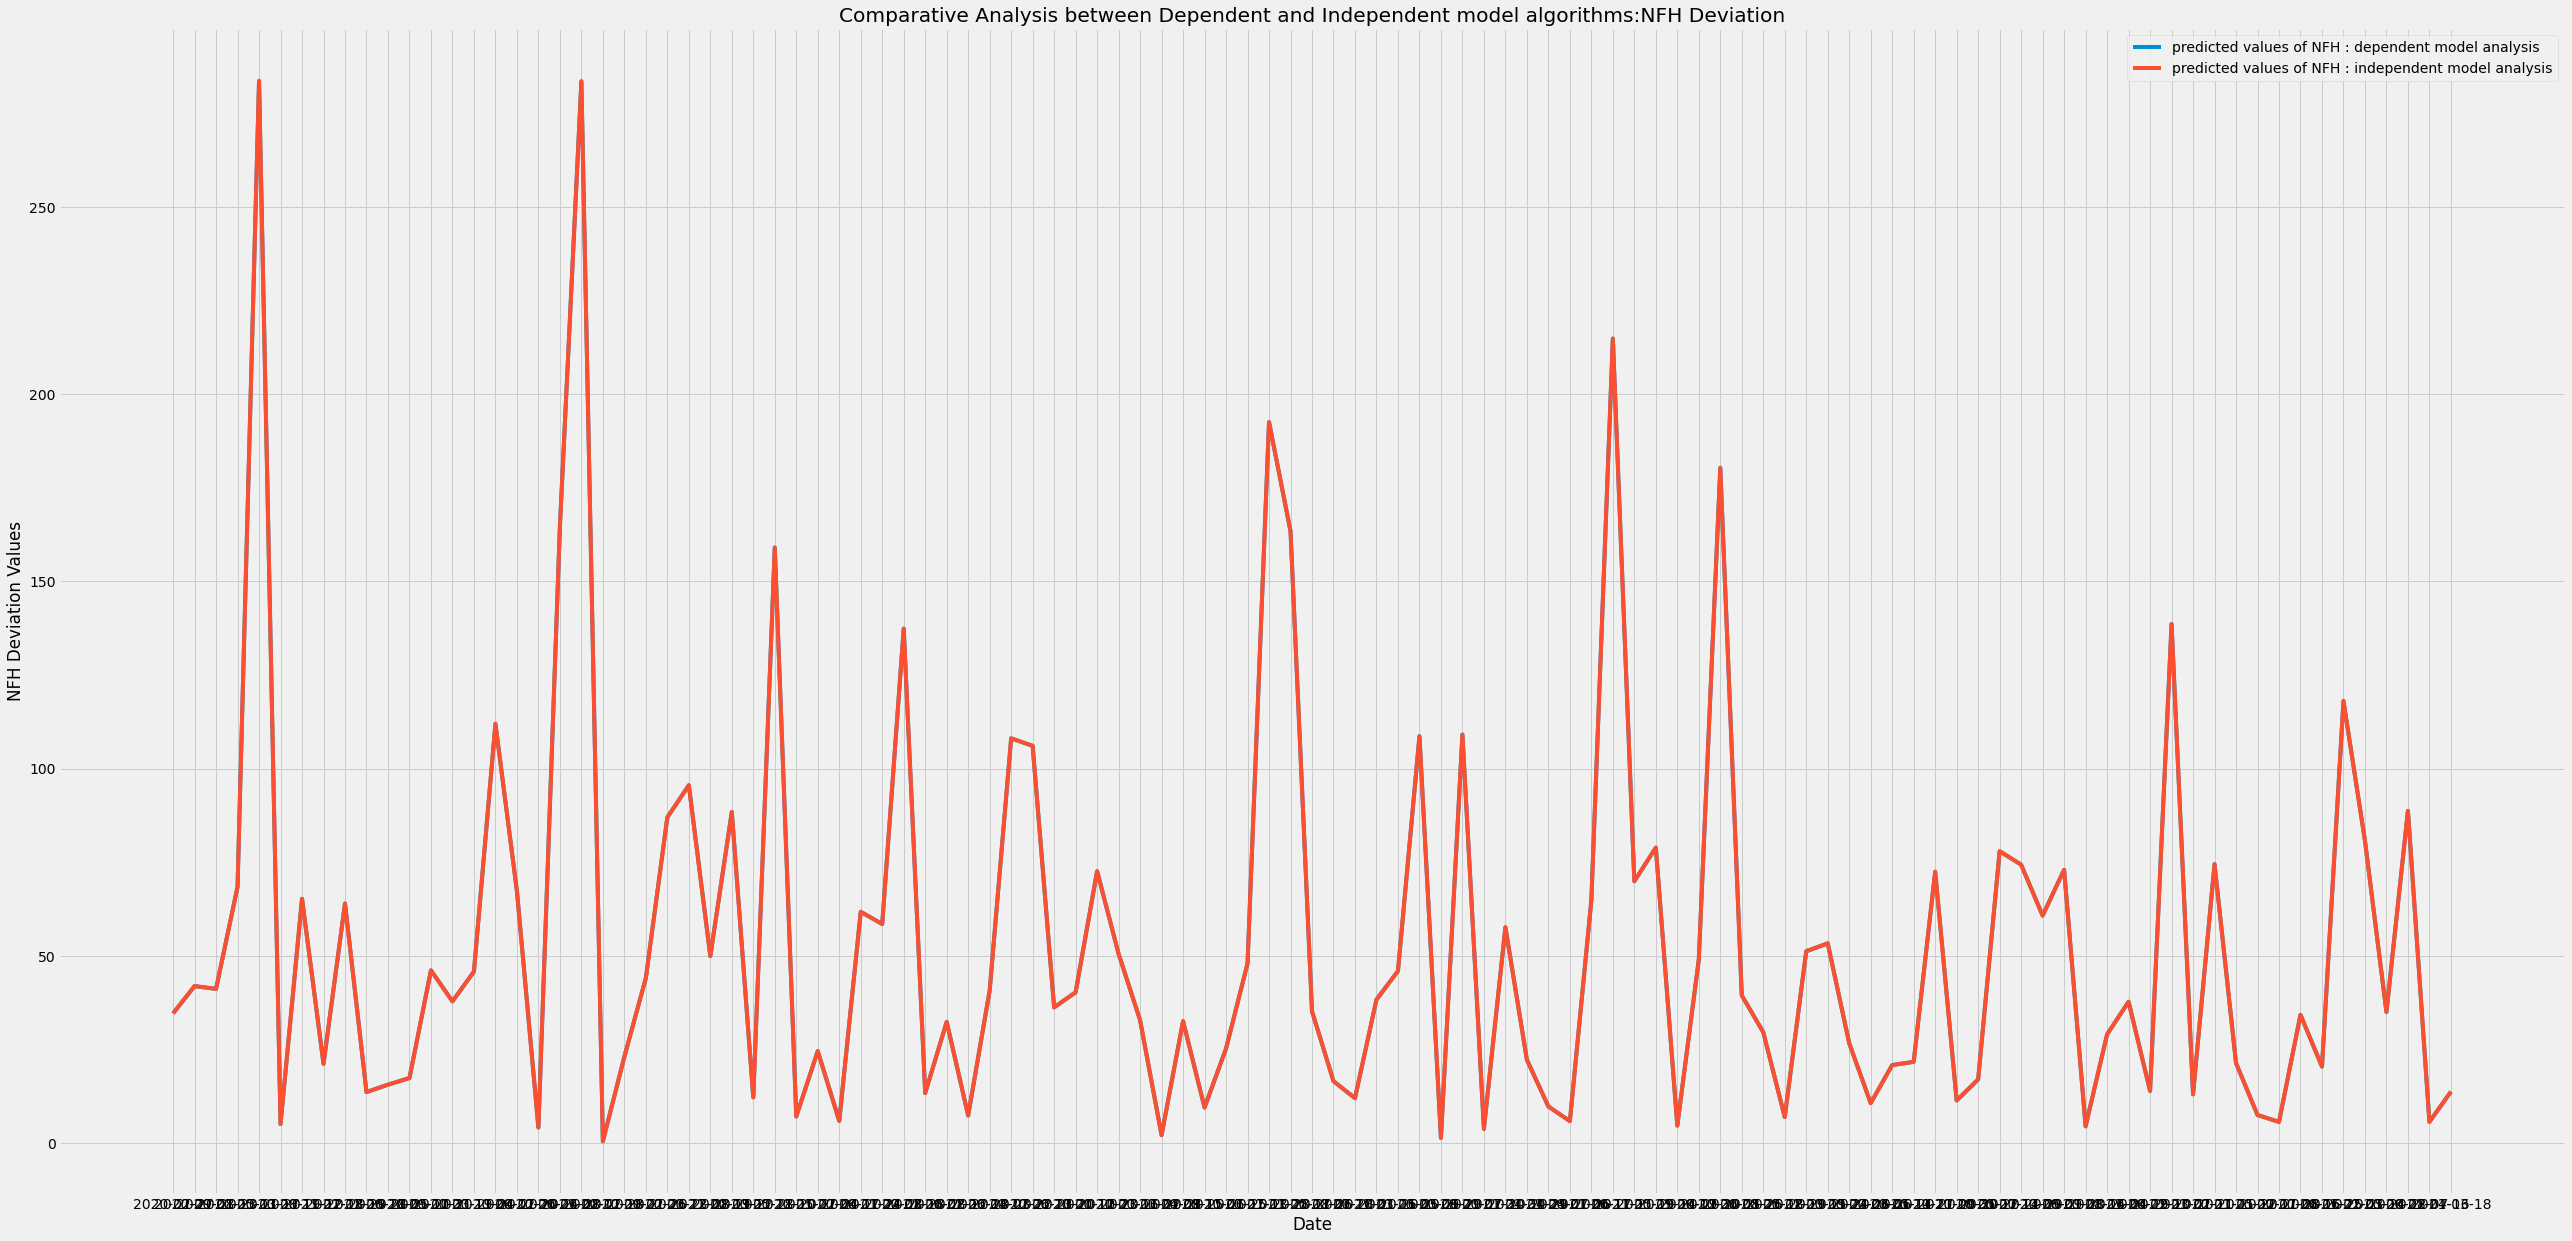

In [78]:
plt.figure(figsize=(40,20))
plt.plot(date,d['Amount of Deviation:NFH (actual vs prediction)'],label='predicted values of NFH : dependent model analysis')
plt.plot(date,id['Amount of Deviation:NFH (actual vs prediction)'],label='predicted values of NFH : independent model analysis')
plt.grid(True)
plt.title('Comparative Analysis between Dependent and Independent model algorithms:NFH Deviation')
plt.legend()
plt.xlabel('Date')
plt.ylabel('NFH Deviation Values')
plt.style.use('fivethirtyeight')
plt.show()

**Graphical Analysis of NFL values**

[2021-08-22 17:53:53] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:53] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:53] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:53] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


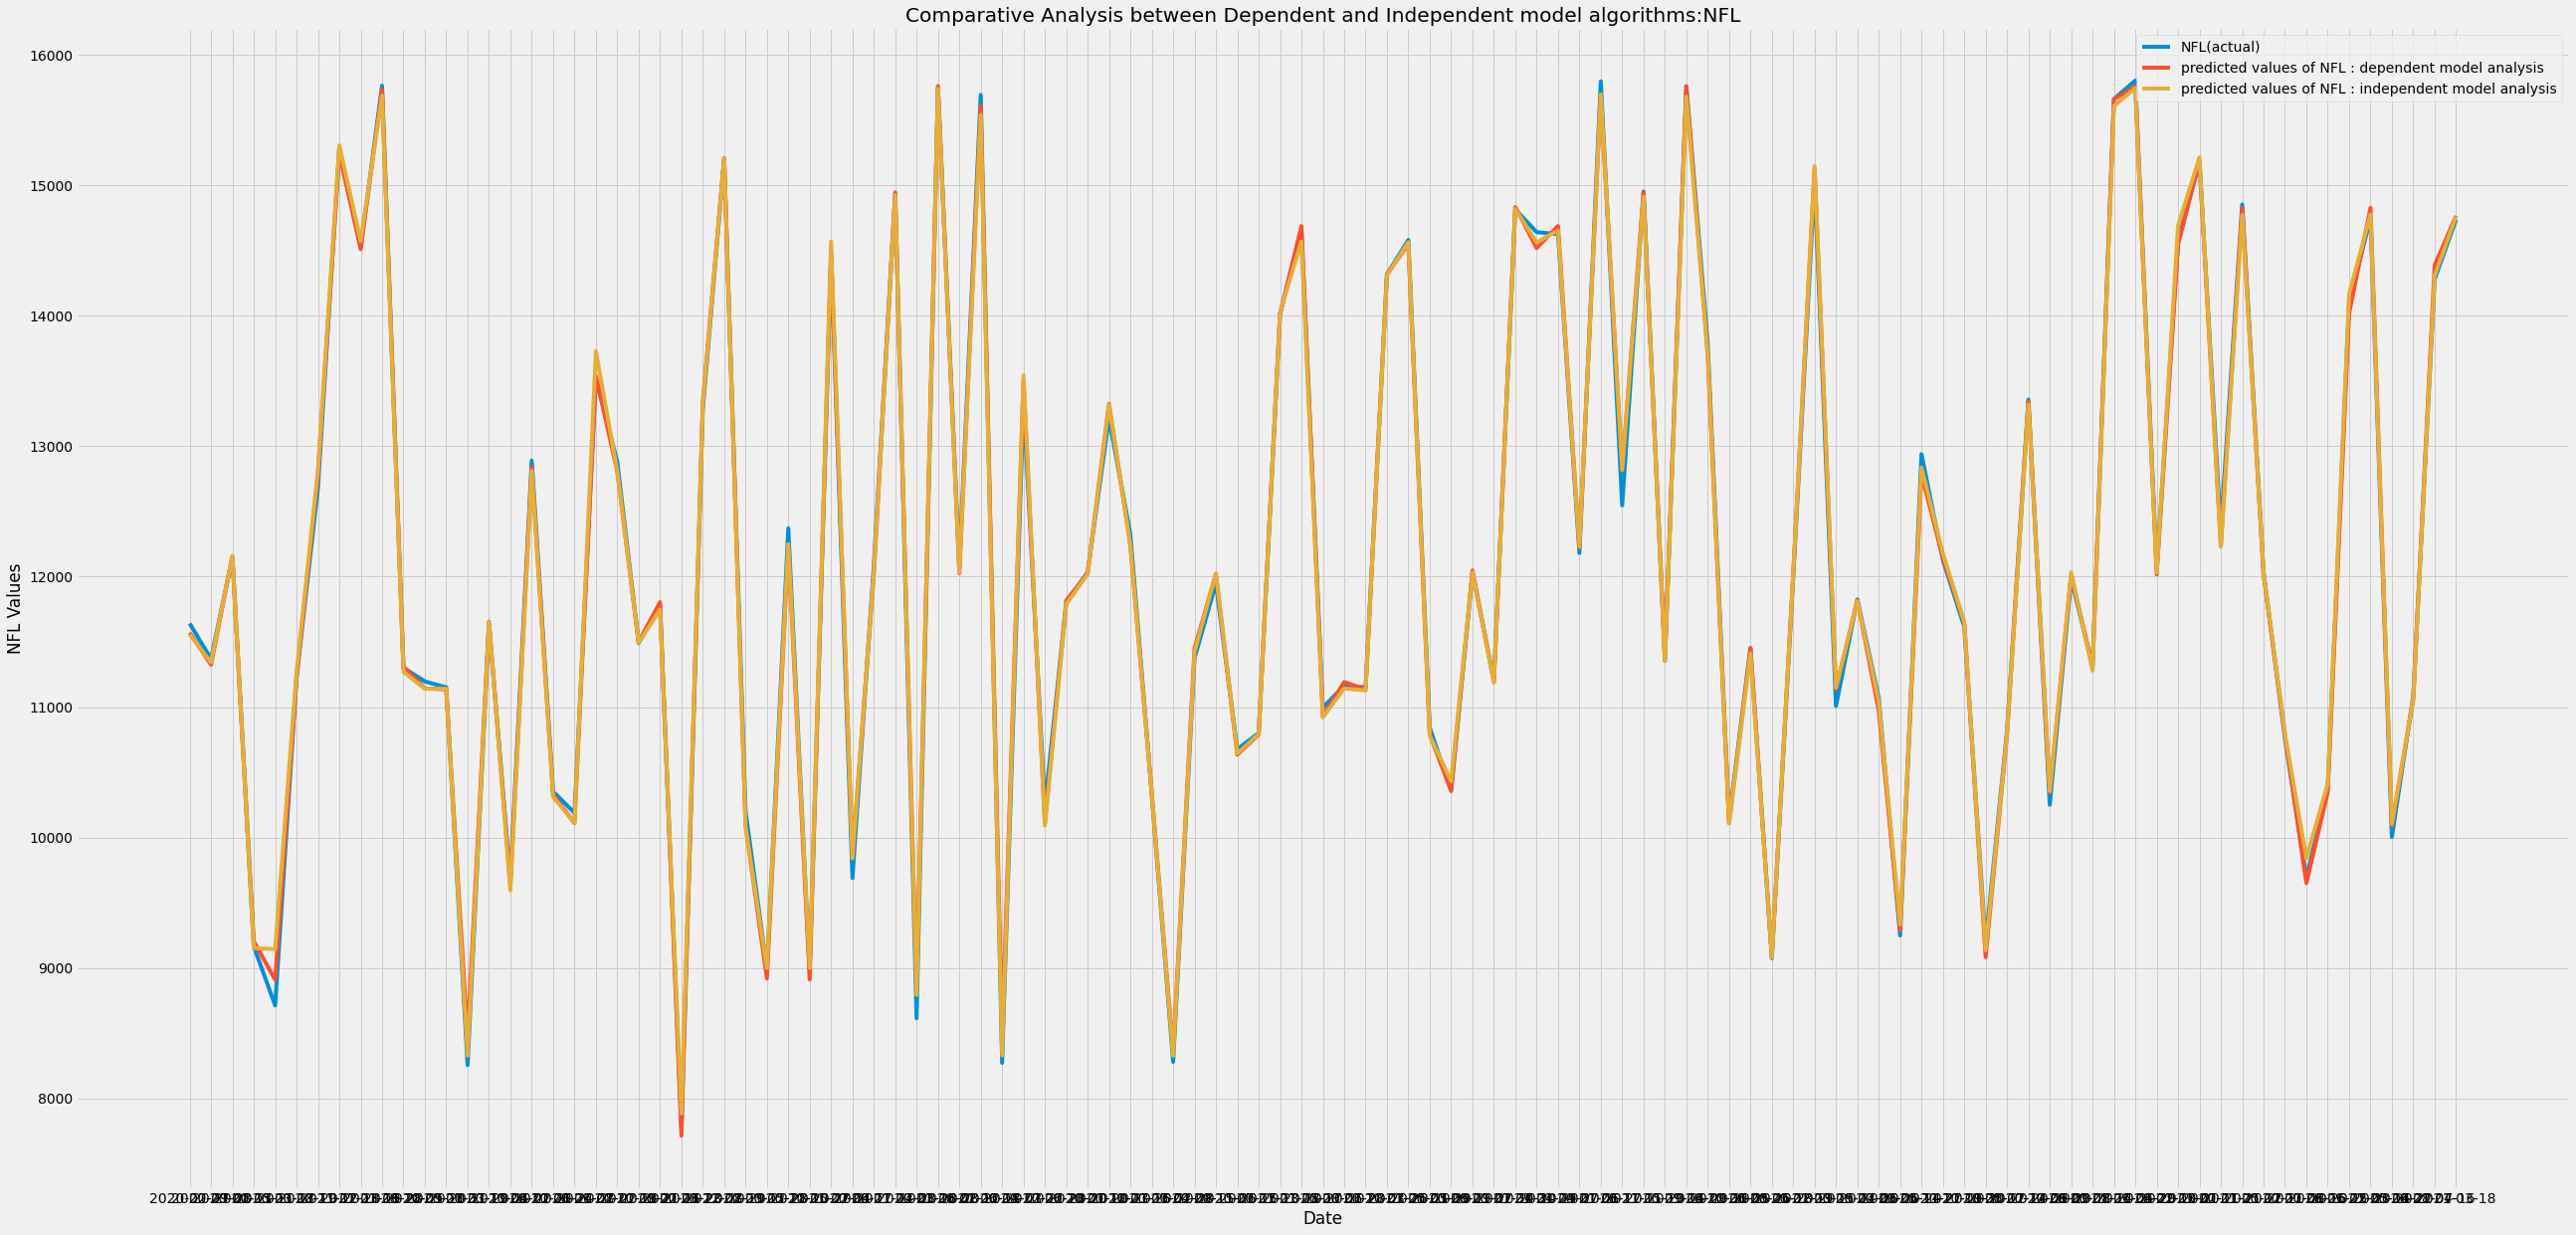

In [79]:
plt.figure(figsize=(40,20))
plt.plot(date,d['NFL(actual)'],label='NFL(actual)')
plt.plot(date,d['NFL(predicted)'],label='predicted values of NFL : dependent model analysis')
plt.plot(date,id['NFL(predicted)'],label='predicted values of NFL : independent model analysis')
plt.grid(True)
plt.title('Comparative Analysis between Dependent and Independent model algorithms:NFL')
plt.legend()
plt.xlabel('Date')
plt.ylabel('NFL Values')
plt.style.use('fivethirtyeight')
plt.show()

**Amount of Deviation between the actual values and the predicted values for both the models based on NFL**

[2021-08-22 17:53:55] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:55] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:55] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2021-08-22 17:53:55] INFO (matplotlib.category/MainThread) Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


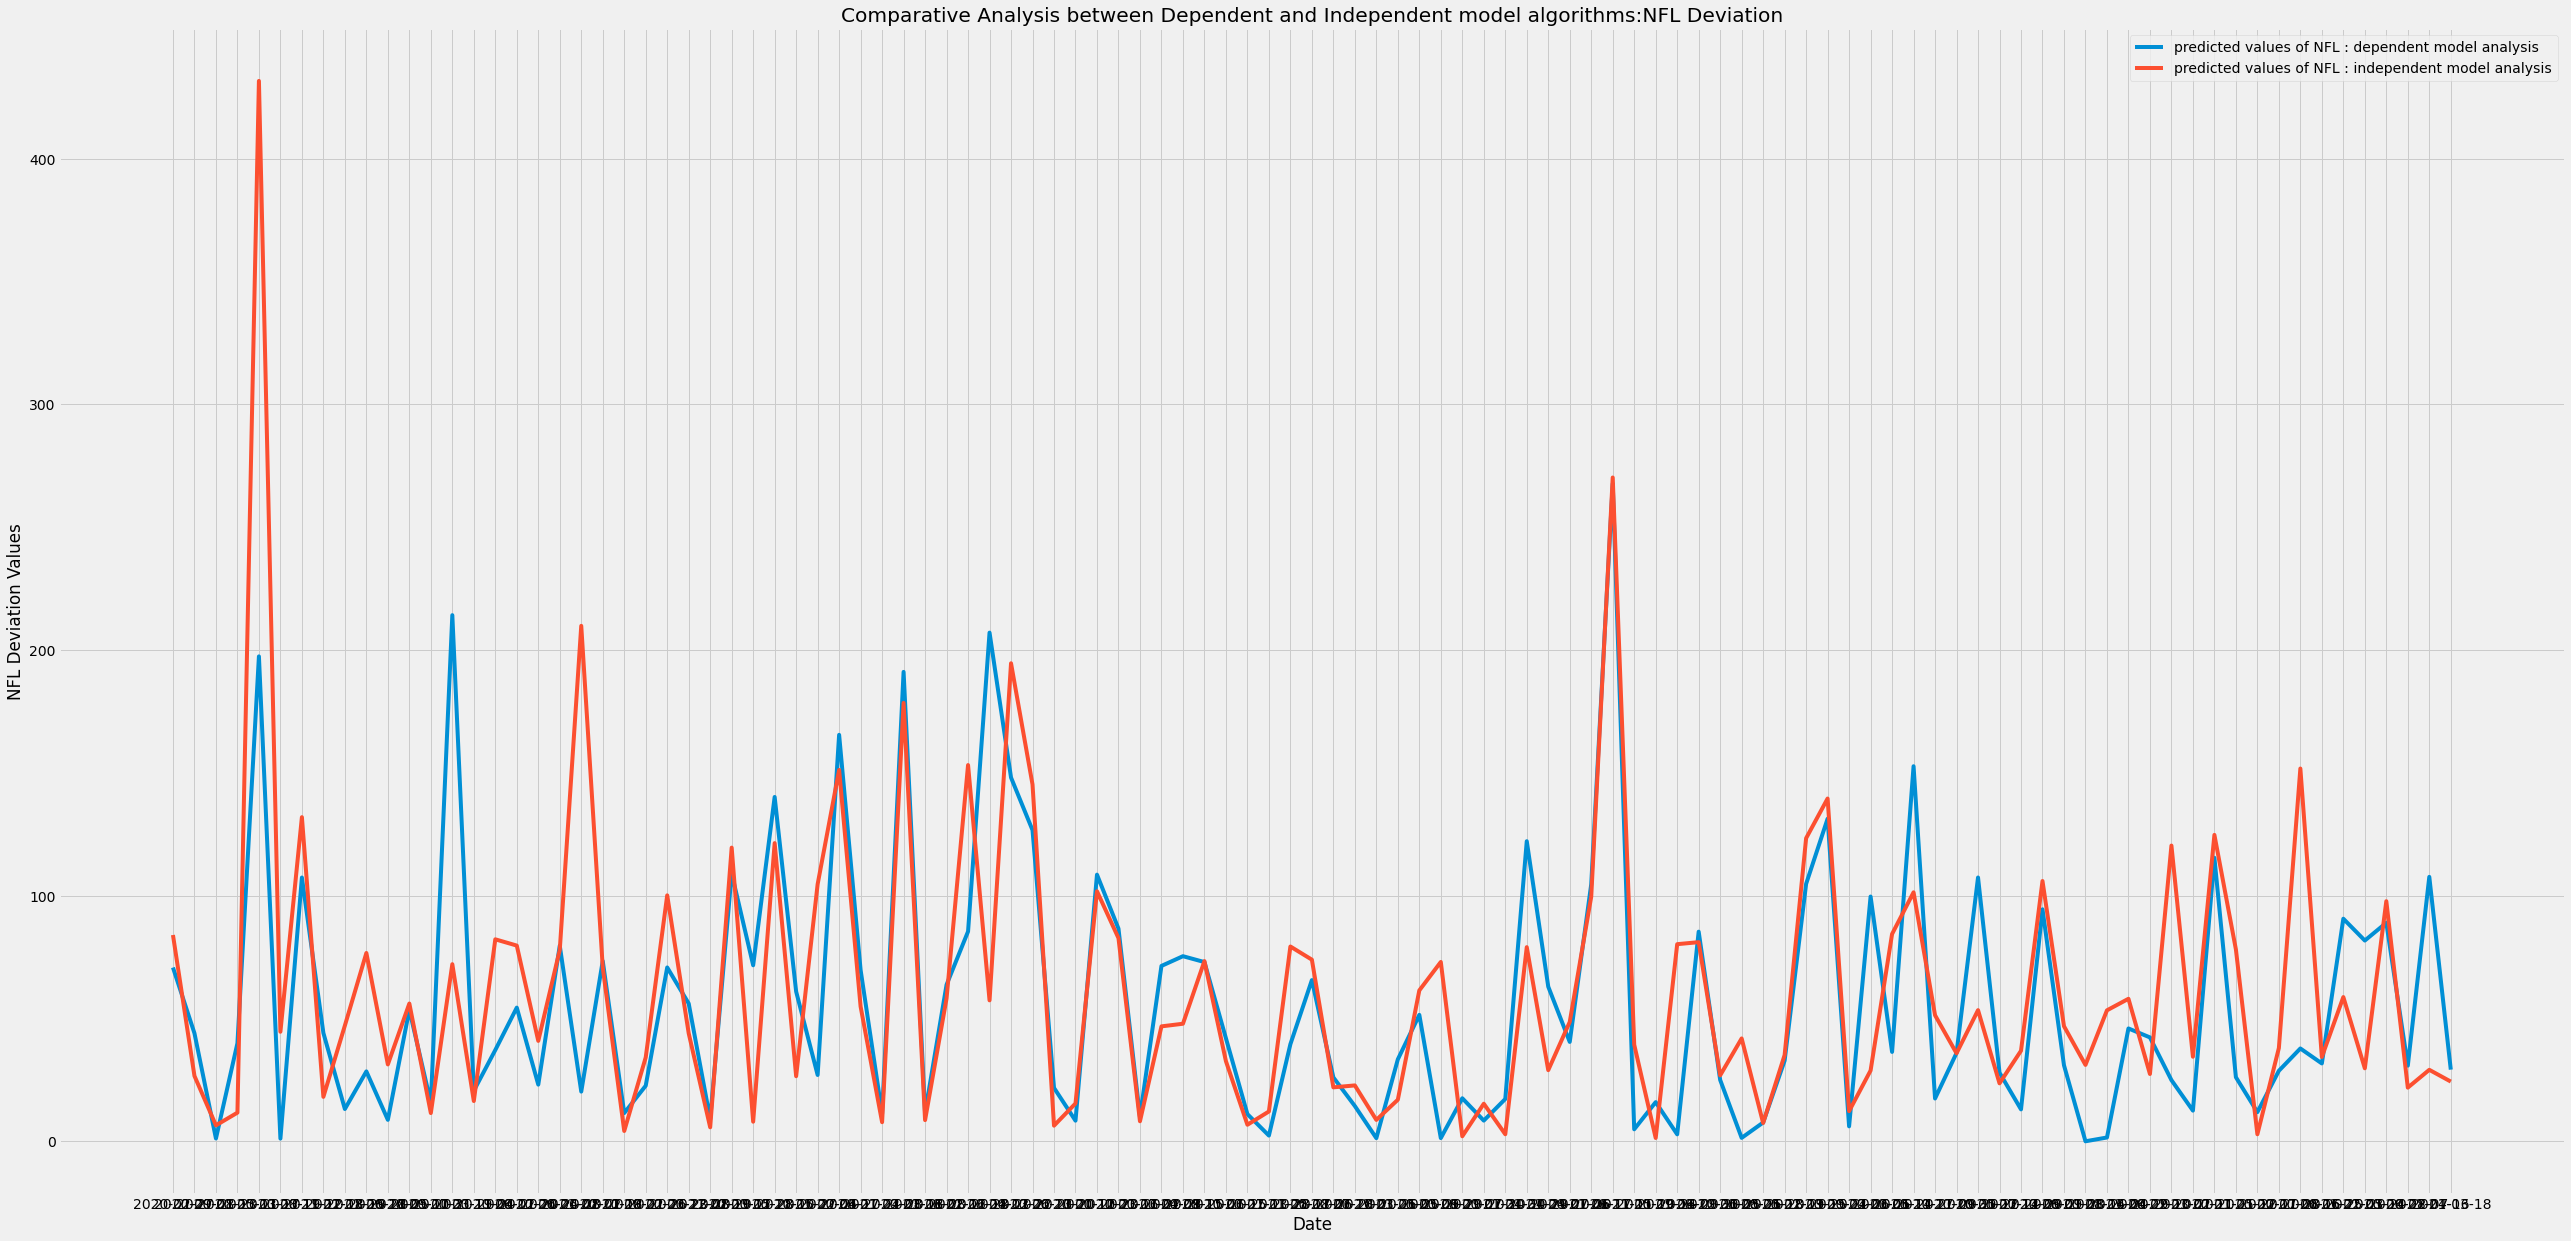

In [80]:
plt.figure(figsize=(40,20))
plt.plot(date,d['Amount of Deviation:NFL (actual vs prediction)'],label='predicted values of NFL : dependent model analysis')
plt.plot(date,id['Amount of Deviation:NFL (actual vs prediction)'],label='predicted values of NFL : independent model analysis')
plt.grid(True)
plt.title('Comparative Analysis between Dependent and Independent model algorithms:NFL Deviation')
plt.legend()
plt.xlabel('Date')
plt.ylabel('NFL Deviation Values')
plt.style.use('fivethirtyeight')
plt.show()

**Based on the above comparative anaylsis graphs sir , one can choose the best model structure/implementation required to train/predict the same**

## **Conclusion**

**I would like to point out that there would be a rare possibility that both the Dependent model analysis.csv, indpendent model analysis.csv would be the same,but due to the fact these models operate using different logic hence the probability of dependent model analysis.csv and independent model analysis.csv would not be the same(i.e there would be a slight difference of values between them), i have enclosed a copy of the datasets for supporting the same sir.**



**Thank you**

